In [2]:
#set up
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import matplotlib.image as mpimg
import numpy as np

# data preprocess

In [3]:
#import glob
# Step 1: Get a list of all CSV files
csv_files = glob.glob('results/*filtered.csv')
csv_files

['results/early_b73_jointModel_filtered.csv',
 'results/early_gt1p_jointModel_filtered.csv',
 'results/early_gt1ra3_defoliated_jointModel_filtered.csv',
 'results/early_gt1ra3_no_treatment_jointModel_filtered.csv',
 'results/early_tb1_jointModel_filtered.csv',
 'results/early_tb1gt1ra3_het_jointModel_filtered.csv',
 'results/early_tb1gt1ra3_jointModel_filtered.csv',
 'results/late_b73_jointModel_filtered.csv',
 'results/late_gt1p_jointModel_filtered.csv',
 'results/late_gt1ra3_defoliated_jointModel_filtered.csv',
 'results/late_gt1ra3_no_treatment_jointModel_filtered.csv',
 'results/late_nt_tb1gt1ra3_jointModel_filtered.csv',
 'results/late_tb1_jointModel_filtered.csv',
 'results/late_tb1gt1ra3_def_jointModel_filtered.csv',
 'results/late_tb1gt1ra3_het_jointModel_filtered.csv']

In [ ]:
# Step 2: Loop through the files and read each one into a DataFrame
df_list = [pd.read_csv(file) for file in csv_files]
# Step 3: Concatenate all DataFrames into one
combined_df = pd.concat(df_list, ignore_index=True)
combined_df

In [5]:
##functions
import numpy as np
import cv2

#assuming mask is [0,1] format
def calcAreaOfBinaryMask(mask):
    return np.sum(mask)

def calcPerimeterofBinaryMask(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    perimeter = cv2.arcLength(contours[0], True)
    return perimeter
    
def calcCircularity(mask):
    mask = mask.astype(np.uint8)
    perimeter = calcPerimeterofBinaryMask(mask)
    area = calcAreaOfBinaryMask(mask)
    circularity = ((4 * np.pi * area)) / (perimeter * perimeter)
    return circularity

#decode RLE mask to binary mask, crop, display all masks
import ast
#mask.decode(ast.literal_eval(finalDf.segm[0]))

def get_bounding_box(pmask):
    # Get the rows and columns where the mask is non-zero
    rows = np.any(pmask, axis=1)
    cols = np.any(pmask, axis=0)
    # Get the bounding box
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def display_masks_grid(masks, rows=9, cols=10):
    # Create a grid of subplots
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    # Flatten axes for easy iteration
    axes_flat = axes.ravel()
    # Turn off axes for any unused subplots
    for ax in axes_flat[len(masks):]:
        ax.axis('off')
    # Display each mask
    for ax, mask in zip(axes_flat, masks):
        ax.imshow(1 - mask, cmap='gray')  # Invert the color
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# circularity by genotype graphs

<AxesSubplot:ylabel='Frequency'>

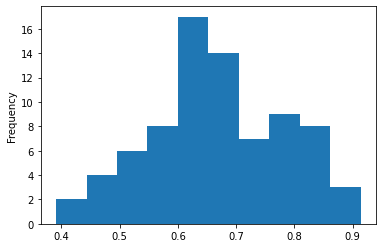

In [9]:
combined_df[combined_df['genotype'] == 'gt1p'].pistil_circularity.plot(kind="hist")

<AxesSubplot:ylabel='Frequency'>

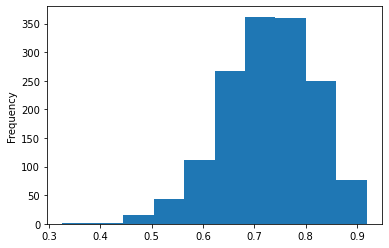

In [10]:
combined_df[combined_df['genotype'] == 'gt1ra3B73'].pistil_circularity.plot(kind="hist")

<AxesSubplot:ylabel='Frequency'>

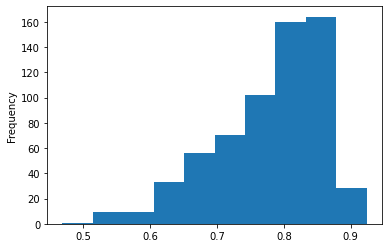

In [11]:
combined_df[combined_df['genotype'] == 'tb1gt1ra3'].pistil_circularity.plot(kind="hist")

<AxesSubplot:ylabel='Frequency'>

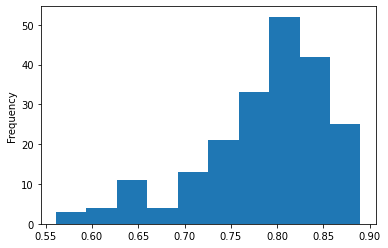

In [12]:
combined_df[combined_df['genotype'] == 'tb1gt1ra3_het'].pistil_circularity.plot(kind="hist")

<AxesSubplot:title={'center':'pistil_circularity'}, xlabel='genotype'>

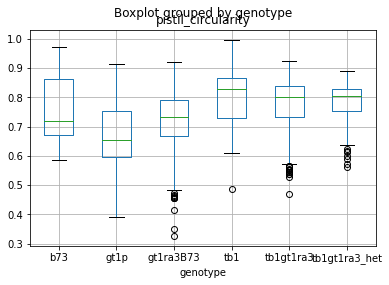

In [16]:
combined_df.boxplot(column='pistil_circularity',by='genotype')

In [ ]:
#check pistil examples to see differences

In [50]:
df = pd.read_csv('/work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/experiments/maize_24UM/results/all_filtered_combined.csv')
#df1= df[df['treatment'] == 'no_treatment']
#finalDf = df1[df1['genotype'] == 'gt1ra3B73'].sample(100)

In [ ]:
#finalDf = df1[df1['genotype'] == 'tb1gt1ra3'].sample(100)
df

In [112]:
# Get list of image_id's that have at least one overlap location
image_ids_with_overlap = [image_id for image_id, locations in overlap_locations.items() if locations.size > 0]

len(np.unique(image_ids_with_overlap))

409

In [ ]:

from pycocotools import mask
import ast

maskList=[]
finalDf = finalDf.sort_values("pistil_circularity")
finalDf = finalDf.reset_index(drop="True")
for row in finalDf.segm:
    pmask=mask.decode(ast.literal_eval(row))
    rmin, rmax, cmin, cmax = get_bounding_box(pmask)
    #crop mask using bounding box
    pmask=pmask[rmin:(rmax+1),cmin:(cmax+1)]
    maskList.append(pmask)

#display_masks_grid(maskList)

#binary_mask = maskList[0]

display_masks_grid(maskList)



dfts=[]
lengths1 = []
widths1 = []


for binary_mask in maskList:
    mask_with_contour = np.copy(binary_mask)
    contours, hierarchy = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    # fit an ellipse to get length and width
    ellipse = cv2.fitEllipse(contours[0])
    (x, y), (major_axis, minor_axis), angle = ellipse
        
    # Append the calculated dimensions
    lengths1.append(max(major_axis, minor_axis))  # Major axis length
    widths1.append(min(major_axis, minor_axis))   # Minor axis length
    
    # Assuming you are interested in the largest contour
    #contour = max(contours, key=cv2.contourArea)
    #complex_contour = np.array([complex(p[0][0], p[0][1]) for p in contour])

    #dfts.append(np.fft.fft(complex_contour))
    # Draw the contour on the mask
    # Blue contour with a thickness of 3
    #mask_with_contour = mask_with_contour.astype(np.uint8)
    #mask_with_contour = cv2.cvtColor(mask_with_contour, cv2.COLOR_GRAY2BGR)
    #cv2.drawContours(mask_with_contour, [contour], -1, (0, 0, 255), 1)
    
    # Draw the ellipse on the overlay mask
    #cv2.ellipse(mask_with_contour, ellipse, (0, 255, 0), 2)  # Green color with thickness 2
        

    # Display the image
    #plt.imshow(mask_with_contour, cmap='gray')  # 'gray' colormap for the binary mask
    #plt.title("Contour Overlaid on Binary Mask")
    #plt.show()

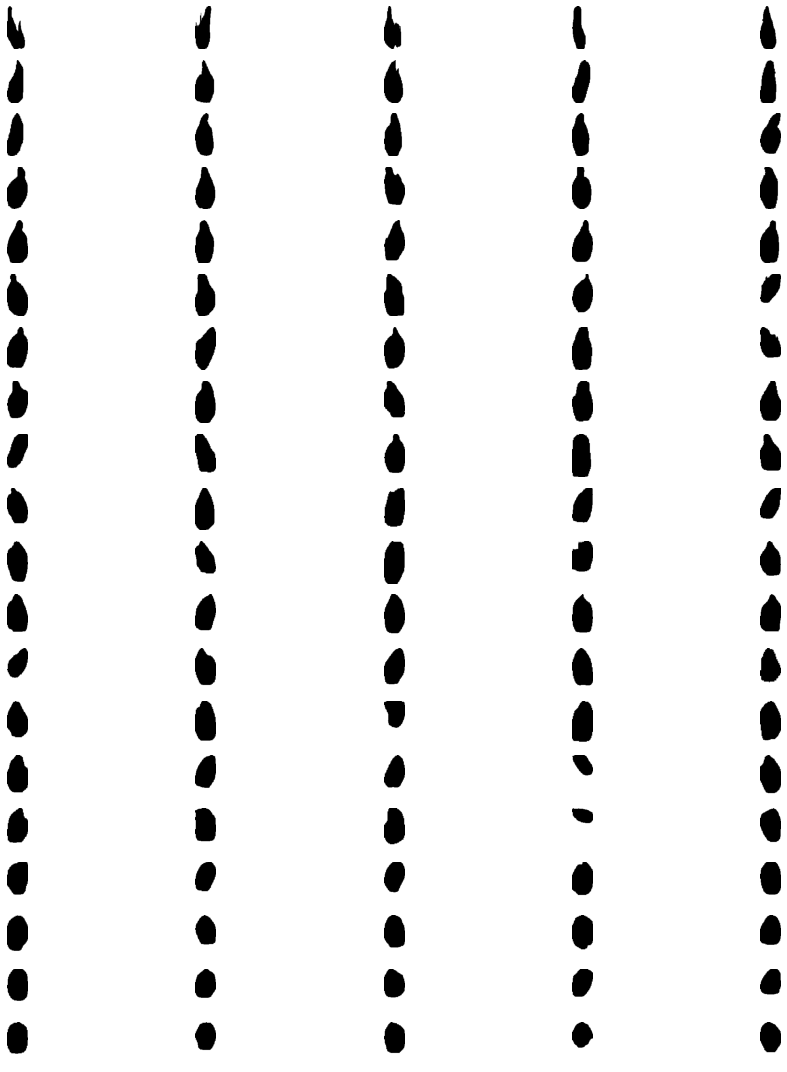

In [87]:
import matplotlib.pyplot as plt
import numpy as np
from pycocotools import mask
import ast
import cv2

maskList = []
finalDf = finalDf.sort_values("pistil_circularity")
finalDf = finalDf.reset_index(drop=True)

# Step 1: Process and collect all masks, also tracking max dimensions
for row in finalDf.segm:
    pmask = mask.decode(ast.literal_eval(row))
    rmin, rmax, cmin, cmax = get_bounding_box(pmask)
    
    # Crop mask using bounding box
    pmask = pmask[rmin:(rmax + 1), cmin:(cmax + 1)]
    maskList.append(pmask)

# Find the maximum height and width across all masks
max_height = max(mask.shape[0] for mask in maskList)
max_width = max(mask.shape[1] for mask in maskList)

# Step 2: Scale each mask, pad to max dimensions, and invert colors
scaled_masks = []
for pmask in maskList:
    # Determine scale based on max dimensions
    scale_factor = min(max_height / pmask.shape[0], max_width / pmask.shape[1])
    
    # Resize mask while maintaining aspect ratio
    scaled_mask = cv2.resize(pmask, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_NEAREST)
    
    # Pad mask to max dimensions to standardize display size
    padded_mask = np.zeros((max_height, max_width), dtype=np.uint8)
    padded_mask[:scaled_mask.shape[0], :scaled_mask.shape[1]] = scaled_mask
    
    # Invert colors (black to white, white to black)
    inverted_mask = cv2.bitwise_not(padded_mask * 255)  # Scale to 0-255 for inversion
    
    scaled_masks.append(inverted_mask)

# Step 3: Display all masks in a grid
def display_masks_grid(masks, grid_cols=5):
    grid_rows = int(np.ceil(len(masks) / grid_cols))
    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(15, 15))
    axes = axes.flatten()
    
    for i, (ax, mask) in enumerate(zip(axes, masks)):
        ax.imshow(mask, cmap='gray')
        ax.axis('off')
    
    # Hide any unused subplots
    for ax in axes[len(masks):]:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Call the function with the inverted masks
display_masks_grid(scaled_masks)



In [72]:
from scipy.stats import ttest_ind

# Perform a paired t-test comparing length and width
t_stat, p_value = ttest_ind(lengths, lengths1)

print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: 6.435401384539621
P-value: 3.543754670272157e-10


In [73]:
from scipy.stats import ttest_ind

# Perform a paired t-test comparing length and width
t_stat, p_value = ttest_ind(widths, widths1)

print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: 1.0628324055865417
P-value: 0.2885024075762397


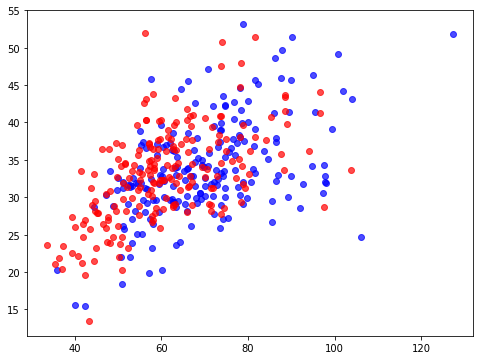

In [75]:
plt.figure(figsize=(8, 6))
plt.scatter(lengths, widths, color='blue', label='gt1ra3', alpha=0.7)
plt.scatter(lengths1, widths1, color='red', label='tb1gt1ra3', alpha=0.7)


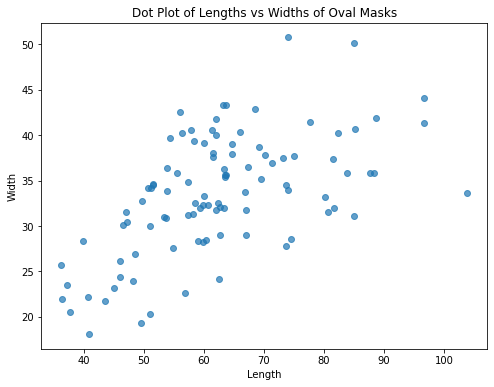

In [54]:
import matplotlib.pyplot as plt

# Assuming 'lengths' and 'widths' contain the lengths and widths for each mask
plt.figure(figsize=(8, 6))

# Create scatter plot
plt.scatter(lengths, widths, alpha=0.7)

# Labeling the axes and title
plt.xlabel("Length")
plt.ylabel("Width")
plt.title("Dot Plot of Lengths vs Widths of Oval Masks")

# Display the plot
plt.show()

## elliptical fourier transform pca

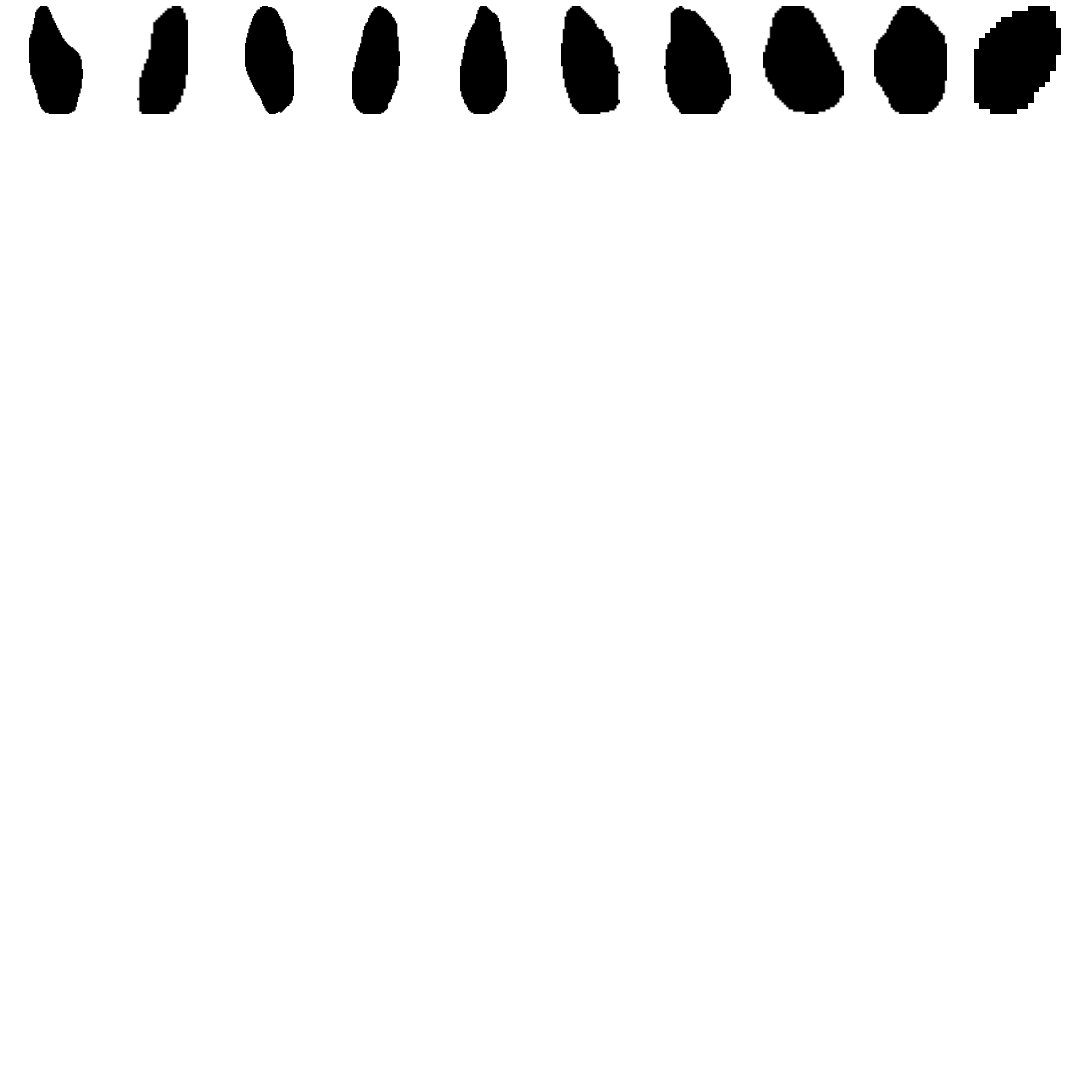

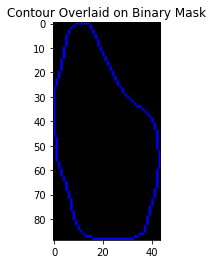

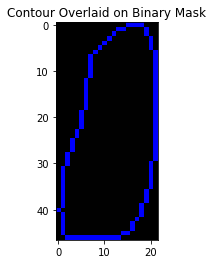

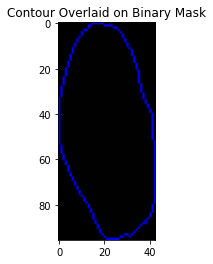

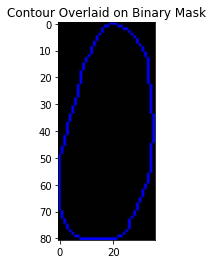

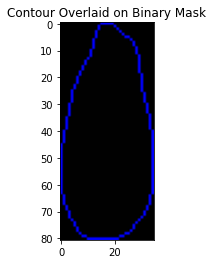

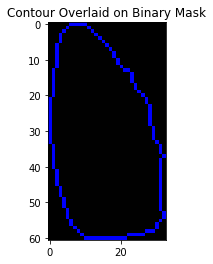

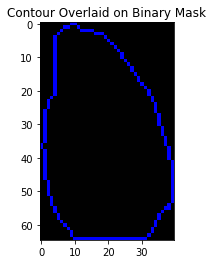

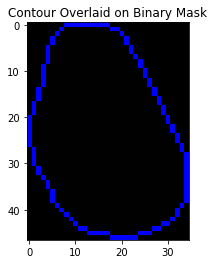

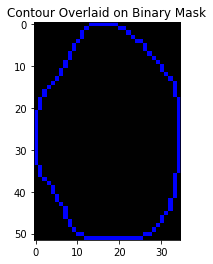

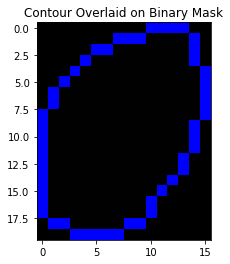

In [9]:
df = pd.read_csv('/work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/experiments/maize_24UM/results/all_filtered_combined.csv')
finalDf = df.sample(10)

from pycocotools import mask
import ast

maskList=[]
finalDf = finalDf.sort_values("pistil_circularity")
finalDf = finalDf.reset_index(drop="True")
for row in finalDf.segm:
    pmask=mask.decode(ast.literal_eval(row))
    rmin, rmax, cmin, cmax = get_bounding_box(pmask)
    #crop mask using bounding box
    pmask=pmask[rmin:(rmax+1),cmin:(cmax+1)]
    maskList.append(pmask)

#display_masks_grid(maskList)

#binary_mask = maskList[0]

display_masks_grid(maskList)



dfts=[]

for binary_mask in maskList:
    mask_with_contour = np.copy(binary_mask)
    contours, hierarchy = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # Assuming you are interested in the largest contour
    contour = max(contours, key=cv2.contourArea)
    complex_contour = np.array([complex(p[0][0], p[0][1]) for p in contour])

    dfts.append(np.fft.fft(complex_contour))
    # Draw the contour on the mask
    # Blue contour with a thickness of 3
    mask_with_contour = mask_with_contour.astype(np.uint8)
    mask_with_contour = cv2.cvtColor(mask_with_contour, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(mask_with_contour, [contour], -1, (0, 0, 255), 1)

    # Display the image
    plt.imshow(mask_with_contour, cmap='gray')  # 'gray' colormap for the binary mask
    plt.title("Contour Overlaid on Binary Mask")
    plt.show()
    # Assuming 'binary_mask' is your binary mask image
    
    # Plotting the magnitude of the Fourier Coefficients
    #plt.plot(np.abs(dft))
    #plt.title('Magnitude of Fourier Coefficients')
    #plt.xlabel('Frequency')
    #plt.ylabel('Magnitude')



In [76]:
from PIL import Image
import numpy as np
c=0
    # Assuming 'binary_mask' is your binary mask as a NumPy array
    # Convert the binary mask to a Pillow Image
for binary_mask in maskList:
    c=c+1
    # Assuming 'binary_mask' is your binary mask as a NumPy array
    height, width = binary_mask.shape
    # Define the border width
    border_width = 200
    # Create a new array with additional pixels for the border
    # The new array will be larger by 'border_width' pixels on each side
    bordered_mask = np.zeros((height + 2 * border_width, width + 2 * border_width), dtype=binary_mask.dtype)
    # Copy the original mask into the center of the new array
    bordered_mask[border_width:-border_width, border_width:-border_width] = binary_mask
    # Convert the binary mask with border to a Pillow image in 'L' mode (grayscale)
    image = Image.fromarray(bordered_mask * 255)  # Scale to 0-255
    rgb_image = image.convert("RGB")
    rgb_image.save('binary_mask' + str(c) +'.bmp')

In [74]:
maskList

[array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0

## test examples

## data preprocessing for SHAPE program input

In [3]:
#generate a unique mask id for each row
df = pd.read_csv('/work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/experiments/maize_24UM/results/all_filtered_combined.csv')
df["mask_id"] = "mask_" + df.index.astype(str)
df

,Unnamed: 0,image_id,planting_date,genotype,treatment,pistil_area,pistil_circularity,bbox,segm,confidence,...,center_y,perimeter_intersect,possible_overlap,scan_position,scan_angle,plant_id,total_scans_for_sample,y_pos_all_overlapped,y_pos_all_overlapped_len_standardized,mask_id
0,0.0,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,early_planting,b73,no_treatment,146,0.8654885686631225,[[410.5882 295.3388 426.31854 311.68604]],"{'size': [672, 1008], 'counts': b'\\P^81ld05N2...",0.9403938,...,368.5,False,False,02,08,_275-5,05,839.5,0.20808531746031747,mask_0
1,0.0,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,early_planting,b73,no_treatment,108,0.9048680065789002,[[400.78745 312.7289 410.93314 329.1174 ]],"{'size': [672, 1008], 'counts': b'Q_W84id05M2M...",0.9594597,...,351.0,False,False,04,08,_275-5,05,1489.0,0.36929563492063494,mask_1
2,0.0,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,early_planting,b73,no_treatment,1366,0.7275947557640956,[[475.69516 167.55325 505.56458 229.67683]],"{'size': [672, 1008], 'counts': b'`Vi9P1oc08H5...",0.94697165,...,473.0,False,False,02,08,_275_3,03,1153.0,0.4289434523809524,mask_2
3,0.0,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,early_planting,b73,no_treatment,1164,0.8508898377209779,[[510.83582 0. 548.4175 39.570732]],"{'size': [672, 1008], 'counts': b'W[_:i0Rd08L2...",0.8827472,...,653.5,True,False,00,08,_275_7,00,653.5,0.9717261904761905,mask_3
4,0.0,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,early_planting,b73,no_treatment,973,0.7086425875393162,[[512.0882 159.58313 533.6663 217.12825]],"{'size': [672, 1008], 'counts': b'iU`:=\\d0>B;...",0.89538884,...,484.5,False,False,02,08,_275_9,02,1187.5,0.5887896825396826,mask_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2462,0.0,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,late_planting,tb1,no_treatment,1476,0.7163430364293106,[[508.45453 75.70345 543.8718 136.99603]],"{'size': [672, 1008], 'counts': b'bT^:`0\\d06J...",0.9144739,...,566.5,False,False,06,08,_288-3,07,3699.5,0.6880580357142857,mask_2462
2463,1.0,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,late_planting,tb1,no_treatment,929,0.8406893441747576,[[505.83975 369.59775 537.69574 411.3391 ]],"{'size': [672, 1008], 'counts': b'm]\\:<ad0302...",0.8985962,...,282.0,False,False,06,08,_288-3,07,1708.0,0.3177083333333333,mask_2463
2464,0.0,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,late_planting,tb1,no_treatment,926,0.6709023254124531,[[326.147 101.974335 347.191 157.53622 ]],"{'size': [672, 1008], 'counts': b'Qgf6e0Qd0=G8...",0.9284745,...,542.0,False,False,00,08,_288-6,00,542.0,0.8065476190476191,mask_2464
2465,0.0,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,late_planting,tb1,no_treatment,122,0.9970227262730132,[[462.973 191.71713 477.23145 205.84348]],"{'size': [672, 1008], 'counts': b'Rf`94kd03N2M...",0.96883225,...,474.0,False,False,06,08,_288-9,07,3052.0,0.5677083333333334,mask_2465


In [4]:
#generate a unique mask id for each row
df = pd.read_csv('/work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/experiments/maize_24UM/results/all_filtered_combined.csv')
df

,Unnamed: 0,image_id,planting_date,genotype,treatment,pistil_area,pistil_circularity,bbox,segm,confidence,center_x,center_y,perimeter_intersect,possible_overlap,scan_position,scan_angle,plant_id,total_scans_for_sample,y_pos_all_overlapped,y_pos_all_overlapped_len_standardized
0,0.0,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,early_planting,b73,no_treatment,146,0.8654885686631225,[[410.5882 295.3388 426.31854 311.68604]],"{'size': [672, 1008], 'counts': b'\\P^81ld05N2...",0.9403938,417.5,368.5,False,False,02,08,_275-5,05,839.5,0.20808531746031747
1,0.0,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,early_planting,b73,no_treatment,108,0.9048680065789002,[[400.78745 312.7289 410.93314 329.1174 ]],"{'size': [672, 1008], 'counts': b'Q_W84id05M2M...",0.9594597,405.0,351.0,False,False,04,08,_275-5,05,1489.0,0.36929563492063494
2,0.0,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,early_planting,b73,no_treatment,1366,0.7275947557640956,[[475.69516 167.55325 505.56458 229.67683]],"{'size': [672, 1008], 'counts': b'`Vi9P1oc08H5...",0.94697165,490.5,473.0,False,False,02,08,_275_3,03,1153.0,0.4289434523809524
3,0.0,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,early_planting,b73,no_treatment,1164,0.8508898377209779,[[510.83582 0. 548.4175 39.570732]],"{'size': [672, 1008], 'counts': b'W[_:i0Rd08L2...",0.8827472,528.5,653.5,True,False,00,08,_275_7,00,653.5,0.9717261904761905
4,0.0,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,early_planting,b73,no_treatment,973,0.7086425875393162,[[512.0882 159.58313 533.6663 217.12825]],"{'size': [672, 1008], 'counts': b'iU`:=\\d0>B;...",0.89538884,522.0,484.5,False,False,02,08,_275_9,02,1187.5,0.5887896825396826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2462,0.0,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,late_planting,tb1,no_treatment,1476,0.7163430364293106,[[508.45453 75.70345 543.8718 136.99603]],"{'size': [672, 1008], 'counts': b'bT^:`0\\d06J...",0.9144739,526.0,566.5,False,False,06,08,_288-3,07,3699.5,0.6880580357142857
2463,1.0,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,late_planting,tb1,no_treatment,929,0.8406893441747576,[[505.83975 369.59775 537.69574 411.3391 ]],"{'size': [672, 1008], 'counts': b'm]\\:<ad0302...",0.8985962,521.0,282.0,False,False,06,08,_288-3,07,1708.0,0.3177083333333333
2464,0.0,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,late_planting,tb1,no_treatment,926,0.6709023254124531,[[326.147 101.974335 347.191 157.53622 ]],"{'size': [672, 1008], 'counts': b'Qgf6e0Qd0=G8...",0.9284745,336.5,542.0,False,False,00,08,_288-6,00,542.0,0.8065476190476191
2465,0.0,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,late_planting,tb1,no_treatment,122,0.9970227262730132,[[462.973 191.71713 477.23145 205.84348]],"{'size': [672, 1008], 'counts': b'Rf`94kd03N2M...",0.96883225,470.0,474.0,False,False,06,08,_288-9,07,3052.0,0.5677083333333334


In [4]:
df.to_csv("all_filtered_combined_rowID_24.csv")

In [68]:
#save location for masks
#save_path = '/work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/experiments/maize_21UM/masks'
from PIL import Image
import os
os.makedirs("masks", exist_ok=True)

for index,row in df.iterrows():
    print(row["mask_id"])
    #RLE to binary encoding
    if row["segm"] == 'segm':
        continue
    
    pmask=mask.decode(ast.literal_eval(row["segm"]))
    rmin, rmax, cmin, cmax = get_bounding_box(pmask)
    #crop mask using bounding box
    pmask=pmask[rmin:(rmax+1),cmin:(cmax+1)]
    height, width = pmask.shape
    # Define the border width (important for SHAPE program)
    border_width = 200
    bordered_mask = np.zeros((height + 2 * border_width, width + 2 * border_width), dtype=pmask.dtype)
    # Copy the original mask into the center of the new array
    bordered_mask[border_width:-border_width, border_width:-border_width] = pmask
    # Convert the binary mask with border to a Pillow image in 'L' mode (grayscale)
    image = Image.fromarray(bordered_mask * 255)  # Scale to 0-255
    rgb_image = image.convert("RGB")
    rgb_image.save("masks/" + str(row["mask_id"]) +'.bmp')

mask_0
mask_1
mask_2
mask_3
mask_4
mask_5
mask_6
mask_7
mask_8
mask_9
mask_10
mask_11
mask_12
mask_13
mask_14
mask_15
mask_16
mask_17
mask_18
mask_19
mask_20
mask_21
mask_22
mask_23
mask_24
mask_25
mask_26
mask_27
mask_28
mask_29
mask_30
mask_31
mask_32
mask_33
mask_34
mask_35
mask_36
mask_37
mask_38
mask_39
mask_40
mask_41
mask_42
mask_43
mask_44
mask_45
mask_46
mask_47
mask_48
mask_49
mask_50
mask_51
mask_52
mask_53
mask_54
mask_55
mask_56
mask_57
mask_58
mask_59
mask_60
mask_61
mask_62
mask_63
mask_64
mask_65
mask_66
mask_67
mask_68
mask_69
mask_70
mask_71
mask_72
mask_73
mask_74
mask_75
mask_76
mask_77
mask_78
mask_79
mask_80
mask_81
mask_82
mask_83
mask_84
mask_85
mask_86
mask_87
mask_88
mask_89
mask_90
mask_91
mask_92
mask_93
mask_94
mask_95
mask_96
mask_97
mask_98
mask_99
mask_100
mask_101
mask_102
mask_103
mask_104
mask_105
mask_106
mask_107
mask_108
mask_109
mask_110
mask_111
mask_112
mask_113
mask_114
mask_115
mask_116
mask_117
mask_118
mask_119
mask_120
mask_121
mask_122
mas

mask_934
mask_935
mask_936
mask_937
mask_938
mask_939
mask_940
mask_941
mask_942
mask_943
mask_944
mask_945
mask_946
mask_947
mask_948
mask_949
mask_950
mask_951
mask_952
mask_953
mask_954
mask_955
mask_956
mask_957
mask_958
mask_959
mask_960
mask_961
mask_962
mask_963
mask_964
mask_965
mask_966
mask_967
mask_968
mask_969
mask_970
mask_971
mask_972
mask_973
mask_974
mask_975
mask_976
mask_977
mask_978
mask_979
mask_980
mask_981
mask_982
mask_983
mask_984
mask_985
mask_986
mask_987
mask_988
mask_989
mask_990
mask_991
mask_992
mask_993
mask_994
mask_995
mask_996
mask_997
mask_998
mask_999
mask_1000
mask_1001
mask_1002
mask_1003
mask_1004
mask_1005
mask_1006
mask_1007
mask_1008
mask_1009
mask_1010
mask_1011
mask_1012
mask_1013
mask_1014
mask_1015
mask_1016
mask_1017
mask_1018
mask_1019
mask_1020
mask_1021
mask_1022
mask_1023
mask_1024
mask_1025
mask_1026
mask_1027
mask_1028
mask_1029
mask_1030
mask_1031
mask_1032
mask_1033
mask_1034
mask_1035
mask_1036
mask_1037
mask_1038
mask_1039
mask_1

mask_1772
mask_1773
mask_1774
mask_1775
mask_1776
mask_1777
mask_1778
mask_1779
mask_1780
mask_1781
mask_1782
mask_1783
mask_1784
mask_1785
mask_1786
mask_1787
mask_1788
mask_1789
mask_1790
mask_1791
mask_1792
mask_1793
mask_1794
mask_1795
mask_1796
mask_1797
mask_1798
mask_1799
mask_1800
mask_1801
mask_1802
mask_1803
mask_1804
mask_1805
mask_1806
mask_1807
mask_1808
mask_1809
mask_1810
mask_1811
mask_1812
mask_1813
mask_1814
mask_1815
mask_1816
mask_1817
mask_1818
mask_1819
mask_1820
mask_1821
mask_1822
mask_1823
mask_1824
mask_1825
mask_1826
mask_1827
mask_1828
mask_1829
mask_1830
mask_1831
mask_1832
mask_1833
mask_1834
mask_1835
mask_1836
mask_1837
mask_1838
mask_1839
mask_1840
mask_1841
mask_1842
mask_1843
mask_1844
mask_1845
mask_1846
mask_1847
mask_1848
mask_1849
mask_1850
mask_1851
mask_1852
mask_1853
mask_1854
mask_1855
mask_1856
mask_1857
mask_1858
mask_1859
mask_1860
mask_1861
mask_1862
mask_1863
mask_1864
mask_1865
mask_1866
mask_1867
mask_1868
mask_1869
mask_1870
mask_1871


In [ ]:
#n = len(file_paths)  # Number of images
#fig, axes = plt.subplots(1, n)  # 1 row, n columns
for i in newImageLocations:
    img = mpimg.imread(i)
    # Set the size of the figure (width, height) in inches
    plt.figure(figsize=(10, 10))  # You can adjust the size as needed

    # Display the image
    plt.imshow(img)

    # Optionally, hide the axes
    plt.axis('off')

    # Show the image
    plt.show()

In [73]:
calcCircularity(mask)

3.141592653589793 52.0 160


0.7435722257017262

## pistil overlap calculations (finding pairs)

In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

def show_image_with_and_without_bboxes(image_id, finalDf, new_path):
    # Find the rows in the DataFrame with the specified image_id
    image_rows = finalDf[finalDf['image_id'] == image_id]
    
    if image_rows.empty:
        print(f"No data found for image_id {image_id}")
        return

    # Load the original image
    img = cv2.imread(new_path)
    if img is None:
        print(f"Could not load image with image_id {image_id}")
        return
    
    # Convert image to RGB for displaying with matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the original image without bounding boxes
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.imshow(img_rgb)
    ax.axis('off')
    plt.title("Original Image")
    plt.show()
    
    # Now display the image with bounding boxes
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.imshow(img_rgb)
    ax.axis('off')

    # Counter for bounding boxes
    bbox_count = 0

    # Iterate over each row with the same image_id to overlay bounding boxes
    for idx, row in image_rows.iterrows():
        try:
            # Extract bounding box coordinates from the bbox column
            #bbox_str = row['bbox'].replace('[', '').replace(']', '')
            #x1, y1, x2, y2 = [float(coord) for coord in bbox_str.split()]

            # Calculate width and height
            #width = x2 - x1
            #height = y2 - y1

            # Create a Rectangle patch
            #rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none', alpha=0.5)

            # Add the rectangle to the Axes
            #ax.add_patch(rect)
            
            # Increment the counter
            #bbox_count += 1
            
            # Define the color mapping for different 'floret_pairs' values
            color_map = {
            'bigger_of_pair': 'red',
            'smaller_of_pair': 'blue',
            'Type C': 'green'
            # Add more types as needed
            }
            # Extract bounding box coordinates from the bbox column
            bbox_str = row['bbox'].replace('[', '').replace(']', '')
            x1, y1, x2, y2 = [float(coord) for coord in bbox_str.split()]

            # Calculate width and height
            width = x2 - x1
            height = y2 - y1

            # Get the color based on 'floret_pairs' value
            floret_pair = row['floret_pairs']
            print(floret_pair)
            color = color_map.get(floret_pair, 'black')  # Default to black if not found in color_map

            # Create a Rectangle patch
            rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor=color, facecolor='none', alpha=0.5)

            # Add the rectangle to the Axes
            ax.add_patch(rect)

            # Increment the counter
            bbox_count += 1
        
        except ValueError as e:
            print(f"Skipping malformed bounding box in row {idx}: {e}")

    # Print the total number of bounding boxes
    print(f"Total number of bounding boxes: {bbox_count}")
    
    # Show the plot with bounding boxes
    plt.title("Image with Bounding Boxes")
    plt.show()



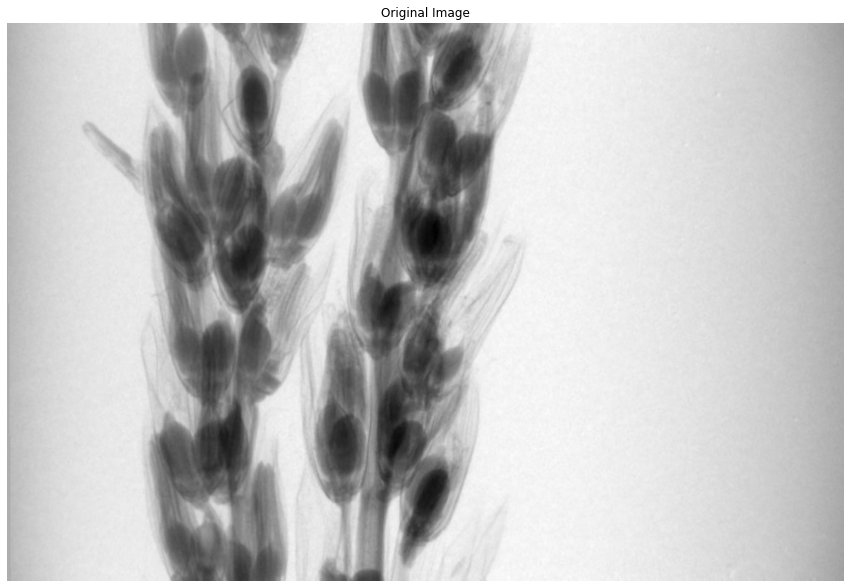

None
bigger_of_pair
None
None
None
None
None
None
None
None
None
None
None
bigger_of_pair
smaller_of_pair
None
None
None
None
smaller_of_pair
None
Total number of bounding boxes: 21


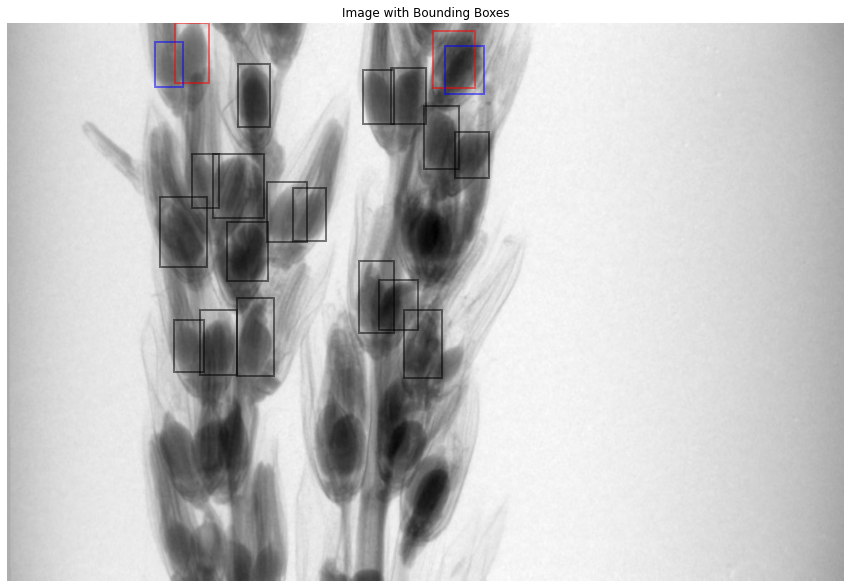

In [52]:
import os
id='158-2~0200000008.jpg'
old_path='/work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/early_planting/gt1ra3B73/no_treatment/'+id
show_image_with_and_without_bboxes(old_path, df, update_path(old_path))


In [ ]:
import pandas as pd
import numpy as np
from itertools import combinations

def get_bounding_box_array(bbox_entry):
    """
    Convert the bbox entry to an array of floats [x1, y1, x2, y2]
    Handles different data formats and checks for valid bounding box content.
    """
    if isinstance(bbox_entry, str):
        # Check for non-numeric entries like 'bbox' and skip them
        if "bbox" in bbox_entry or not any(char.isdigit() for char in bbox_entry):
            print(f"Skipping invalid bbox entry: {bbox_entry}")
            return None
        # Remove any unwanted characters and split
        bbox_str = bbox_entry.strip('[]')
        numbers = bbox_str.replace(',', ' ').split()
        try:
            return [float(num) for num in numbers]
        except ValueError:
            print(f"Could not convert bbox string to float: {bbox_entry}")
            return None
    elif isinstance(bbox_entry, (list, tuple, np.ndarray)):
        # If it's already a list or array, ensure all elements are numbers
        if all(isinstance(num, (int, float)) for num in bbox_entry):
            return list(bbox_entry)
        else:
            print(f"Non-numerical values in bbox: {bbox_entry}")
            return None
    elif isinstance(bbox_entry, dict):
        # If bbox is a dictionary with keys
        keys = ['x1', 'y1', 'x2', 'y2']
        try:
            return [float(bbox_entry[key]) for key in keys]
        except (KeyError, ValueError) as e:
            print(f"Error parsing bbox dictionary: {bbox_entry}, Error: {e}")
            return None
    else:
        print(f"Unsupported bbox format: {bbox_entry}")
        return None

def compute_intersection_area(bbox1, bbox2, bbox3):
    """
    Compute the intersection area of three bounding boxes
    """
    # Compute the intersection coordinates
    x_left = max(bbox1[0], bbox2[0], bbox3[0])
    y_top = max(bbox1[1], bbox2[1], bbox3[1])
    x_right = min(bbox1[2], bbox2[2], bbox3[2])
    y_bottom = min(bbox1[3], bbox2[3], bbox3[3])

    # Check if there is an overlap
    if x_right <= x_left or y_bottom <= y_top:
        return 0.0
    else:
        return (x_right - x_left) * (y_bottom - y_top)

def find_images_with_triple_overlap(df):
    # Create a set to hold image_ids with triple overlaps
    image_ids_with_triple_overlap = set()
    
    # Group the dataframe by image_id
    grouped = df.groupby('image_id')
    
    for image_id, group in grouped:
        # Check if there are at least 3 detections
        if len(group) < 3:
            continue
        
        # Extract the bounding boxes
        bboxes = group['bbox'].tolist()
        bbox_arrays = []
        for bbox_entry in bboxes:
            bbox_array = get_bounding_box_array(bbox_entry)
            if bbox_array is not None:
                bbox_arrays.append(bbox_array)
        
        if len(bbox_arrays) < 3:
            continue  # Not enough valid bounding boxes
        
        # Generate all combinations of three bounding boxes
        for bbox_triplet in combinations(bbox_arrays, 3):
            bbox1, bbox2, bbox3 = bbox_triplet
            # Compute the intersection area of the three bounding boxes
            intersection_area = compute_intersection_area(bbox1, bbox2, bbox3)
            if intersection_area > 0:
                # There is an overlap among the three boxes
                image_ids_with_triple_overlap.add(image_id)
                break  # No need to check other combinations for this image
    return list(image_ids_with_triple_overlap)

# Example usage:
# Assuming your dataframe is named 'df' and has a 'bbox' column formatted as described.
image_ids_with_overlap = find_images_with_triple_overlap(df)
print("Images with at least three overlapping bounding boxes:")
print(image_ids_with_overlap)


In [12]:
def update_path(old_path):
    # Split the path into parts
    parts = old_path.split('/')
    
    # Insert "experiments" after "grass_carpel_ml_quantification_final"
    parts.insert(parts.index("grass_carpel_ml_quantification_final") + 1, "experiments")
    
    # Swap "data" and "maize_21UM_data", and change "maize_21UM_data" to "maize_21UM"
    data_index = parts.index("data")
    maize_index = parts.index("maize_21UM_data")
    parts[data_index], parts[maize_index] = "maize_21UM", "data"
    
    # Join the parts back into a single path
    new_path =  "/" + os.path.join(*parts)
    return new_path

#for x in image_ids_with_overlap:

    # Example usage
#    old_path = x
 #   new_path = update_path(old_path)
 #   print("Updated path:", new_path)

  #  show_image_with_and_without_bboxes(x,df, new_path)

In [ ]:
#24um check
df = pd.read_csv('/work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/experiments/maize_24UM/results/all_filtered_combined.csv')

image_ids_with_overlap = find_images_with_triple_overlap(df)


In [54]:
image_ids_with_overlap

['/work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/experiments/maize_24UM/data/early_planting/gt1ra3B73/no_treatment/gt1ra3_266-3~0300000008.jpg',
 '/work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/experiments/maize_24UM/data/late_planting/tb1gt1ra3/no_treatment/tb1gt1ra3_281-1~0100000008.jpg',
 '/work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/experiments/maize_24UM/data/early_planting/gt1ra3B73/no_treatment/gt1ra3_266-5~0100000008.jpg']

In [ ]:
for x in image_ids_with_overlap:
    show_image_with_and_without_bboxes(x,df, x)

## pistil PCA overlay test

In [47]:
import matplotlib
from PIL import Image, ImageOps
df = pd.read_csv('/work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/experiments/maize_24UM/results/joined_df_pre_5_pistil_count_filter.csv')


In [7]:
df

,Unnamed: 0.1,row_labels,PC1,PC2,PC3,PC4,...1,Unnamed: 0,image_id,planting_date,...,possible_overlap,scan_position,scan_angle,plant_id,total_scans_for_sample,y_pos_all_overlapped,y_pos_all_overlapped_len_standardized,mask_id,year,plant
0,1,mask_0_1,-1.418717,-0.449939,0.436871,-3.141194,0,0,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,early_planting,...,False,5,8,155-6,5,1969.0,0.488343,mask_0,21,B73_155-6
1,2,mask_0_12,-3.584005,2.016978,0.038715,6.257783,0,0,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,early_planting,...,False,2,8,275-5,5,839.5,0.208085,mask_0,24,B73_275-5
2,3,mask_1_1,5.191034,1.344810,-1.161118,-0.414239,1,0,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,early_planting,...,False,3,8,159-4,3,1118.0,0.415923,mask_1,21,B73_159-4
3,4,mask_1_12,-1.915877,-2.034317,-3.474113,1.007381,1,0,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,early_planting,...,False,4,8,275-5,5,1489.0,0.369296,mask_1,24,B73_275-5
4,5,mask_10_1,2.895338,0.687096,1.753246,0.092970,10,0,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,early_planting,...,False,6,8,153-2,7,3185.0,0.592448,mask_10,21,gt1B73_153-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5962,5963,mask_997_12,-6.437020,-3.061333,2.348038,-1.749195,997,0,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,early_planting,...,False,1,8,272-3,8,677.0,0.111938,mask_997,24,tb1_272-3
5963,5964,mask_998_1,0.730174,3.747580,0.937258,2.531282,998,12,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,early_planting,...,False,3,8,158-4,6,1558.0,0.331207,mask_998,21,gt1ra3B73_158-4
5964,5965,mask_998_12,1.566859,0.179747,2.294524,-0.339338,998,0,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,early_planting,...,False,7,8,272-3,8,3450.0,0.570437,mask_998,24,tb1_272-3
5965,5966,mask_999_1,-0.464340,-1.389856,0.113244,0.445627,999,0,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,early_planting,...,False,4,8,158-4,6,2661.5,0.565689,mask_999,21,gt1ra3B73_158-4


In [56]:
df = pd.read_csv('/work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/experiments/maize_24UM/results/joined_df_pre_5_pistil_count_filter.csv')
df = df[df['genotype'] == 'gt1p']

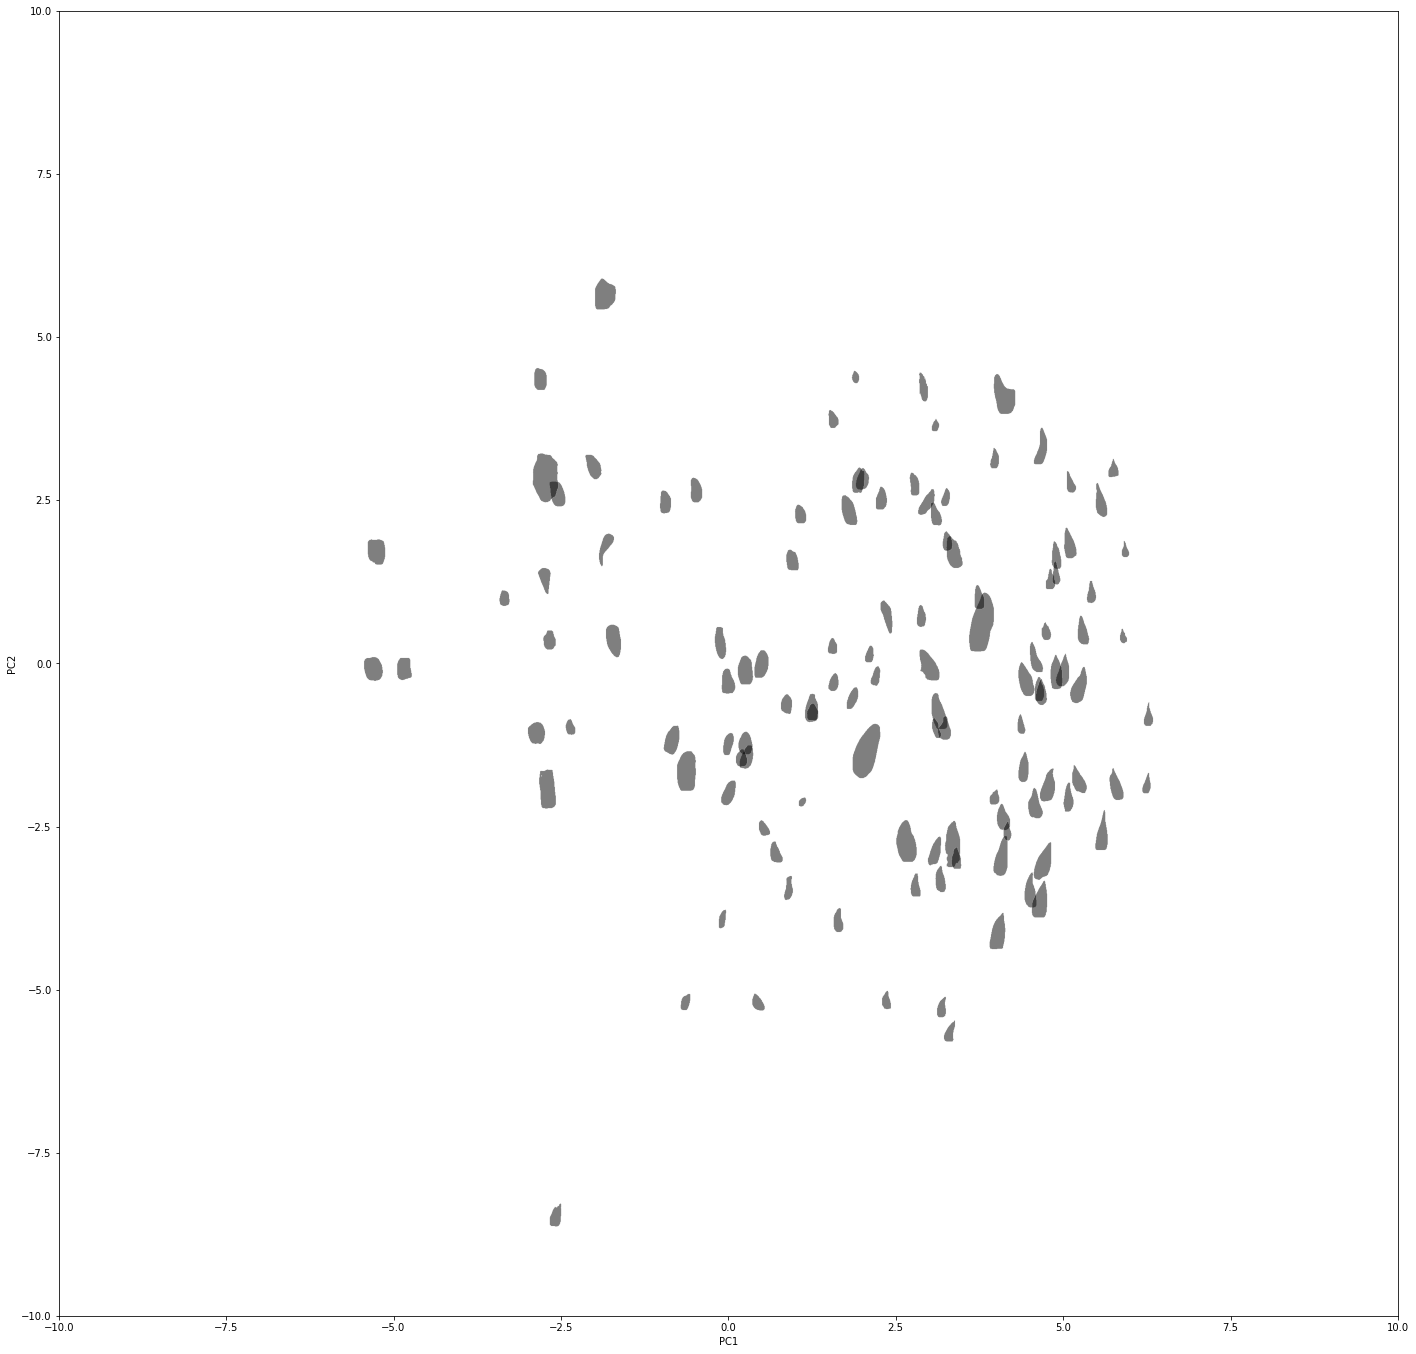

In [57]:
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

# Create plot
fig, ax = plt.subplots(figsize=(24, 24))  # Adjust size as needed

ax.scatter(df['PC1'], df['PC2'], color='none')  # Use transparent points to mark coordinates

for _, row in df.iterrows():
    mask_id = row['mask_id']
    year = row['year']
    if year == 21:
        path = '/work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/experiments/maize_21UM/masks/' + mask_id + '.bmp'
    elif year == 24:
        path = '/work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/experiments/maize_24UM/masks/' + mask_id + '.bmp'
    #if mask_id == 'mask_100':
     #   break
    # Load image, invert colors, and convert to RGBA
    img = Image.open(path)
    img = ImageOps.invert(img).convert("RGBA")

    # Make the white background transparent
    datas = img.getdata()
    new_data = []
    for item in datas:
        # Check if the pixel is near-white or near-black
        if item[0] > 200 and item[1] > 200 and item[2] > 200:  # Near-white
            new_data.append((255, 255, 255, 0))  # Set to transparent
        elif item[0] < 50 and item[1] < 50 and item[2] < 50:  # Near-black
            new_data.append((0, 0, 0, 128))  # Set to transparent
        else:
            new_data.append(item)  # Keep original pixel
    img.putdata(new_data)

    # Get coordinates
    x, y = row['PC1'], row['PC2']

    # Overlay image on the plot with an increased extent range for larger image size
    ax.imshow(img, extent=(x - 1.5, x + 1.5, y - 1.5, y + 1.5), aspect='auto')  # Adjust extent as needed

ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.savefig("gt1p_pistilimgpca.png", dpi=300, bbox_inches='tight')  # Saves as a PNG with high resolution

plt.show()


In [3]:
df = pd.read_csv('/work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/experiments/maize_24UM/results/joined_df_pre_5_pistil_count_filter.csv')

dfn = df[df['genotype'] == 'gt1ra3B73']
dfn = dfn.sample(n=300)
dfn

,Unnamed: 0.1,row_labels,PC1,PC2,PC3,PC4,...1,Unnamed: 0,image_id,planting_date,...,possible_overlap,scan_position,scan_angle,plant_id,total_scans_for_sample,y_pos_all_overlapped,y_pos_all_overlapped_len_standardized,mask_id,year,plant
3567,3568,mask_2740_1,-5.196218,-1.237225,-3.947843,-1.735575,2740,18,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,late_planting,...,False,6,8,409-4,9,4270.0,0.635417,mask_2740,21,gt1ra3B73_409-4
3528,3529,mask_2709_1,-3.369071,0.607557,0.742568,1.620197,2709,19,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,late_planting,...,False,4,8,409-4,9,2776.5,0.413095,mask_2709,21,gt1ra3B73_409-4
5209,5210,mask_654_1,3.641501,1.565531,-1.605559,-3.439696,654,7,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,early_planting,...,False,7,8,154-4,8,2614.0,0.432209,mask_654,21,gt1ra3B73_154-4
3735,3736,mask_288_1,2.165201,0.960537,-1.624856,2.098805,288,6,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,early_planting,...,False,1,8,158-3,4,755.0,0.224702,mask_288,21,gt1ra3B73_158-3
2493,2494,mask_2131_1,-0.067309,-2.620623,-0.613793,0.275528,2131,2,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,late_planting,...,False,3,8,405-6,8,2108.0,0.348545,mask_2131,21,gt1ra3B73_405-6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
903,904,mask_1413_1,1.570182,3.770808,2.614115,0.327775,1413,19,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,late_planting,...,False,2,8,405-9,9,1273.0,0.189435,mask_1413,21,gt1ra3B73_405-9
1301,1302,mask_1593_1,-2.748220,-2.467692,-4.190383,1.284107,1593,9,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,late_planting,...,False,1,8,409-3,7,844.0,0.156994,mask_1593,21,gt1ra3B73_409-3
3387,3388,mask_2594_1,-0.655674,3.654822,1.480159,-1.937887,2594,6,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,late_planting,...,False,4,8,409-2,8,1686.5,0.278770,mask_2594,21,gt1ra3B73_409-2
5183,5184,mask_641_12,0.567982,-4.397245,2.532042,-0.540172,641,5,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,early_planting,...,False,5,8,267-7,9,2035.0,0.302827,mask_641,24,gt1ra3B73_267-7


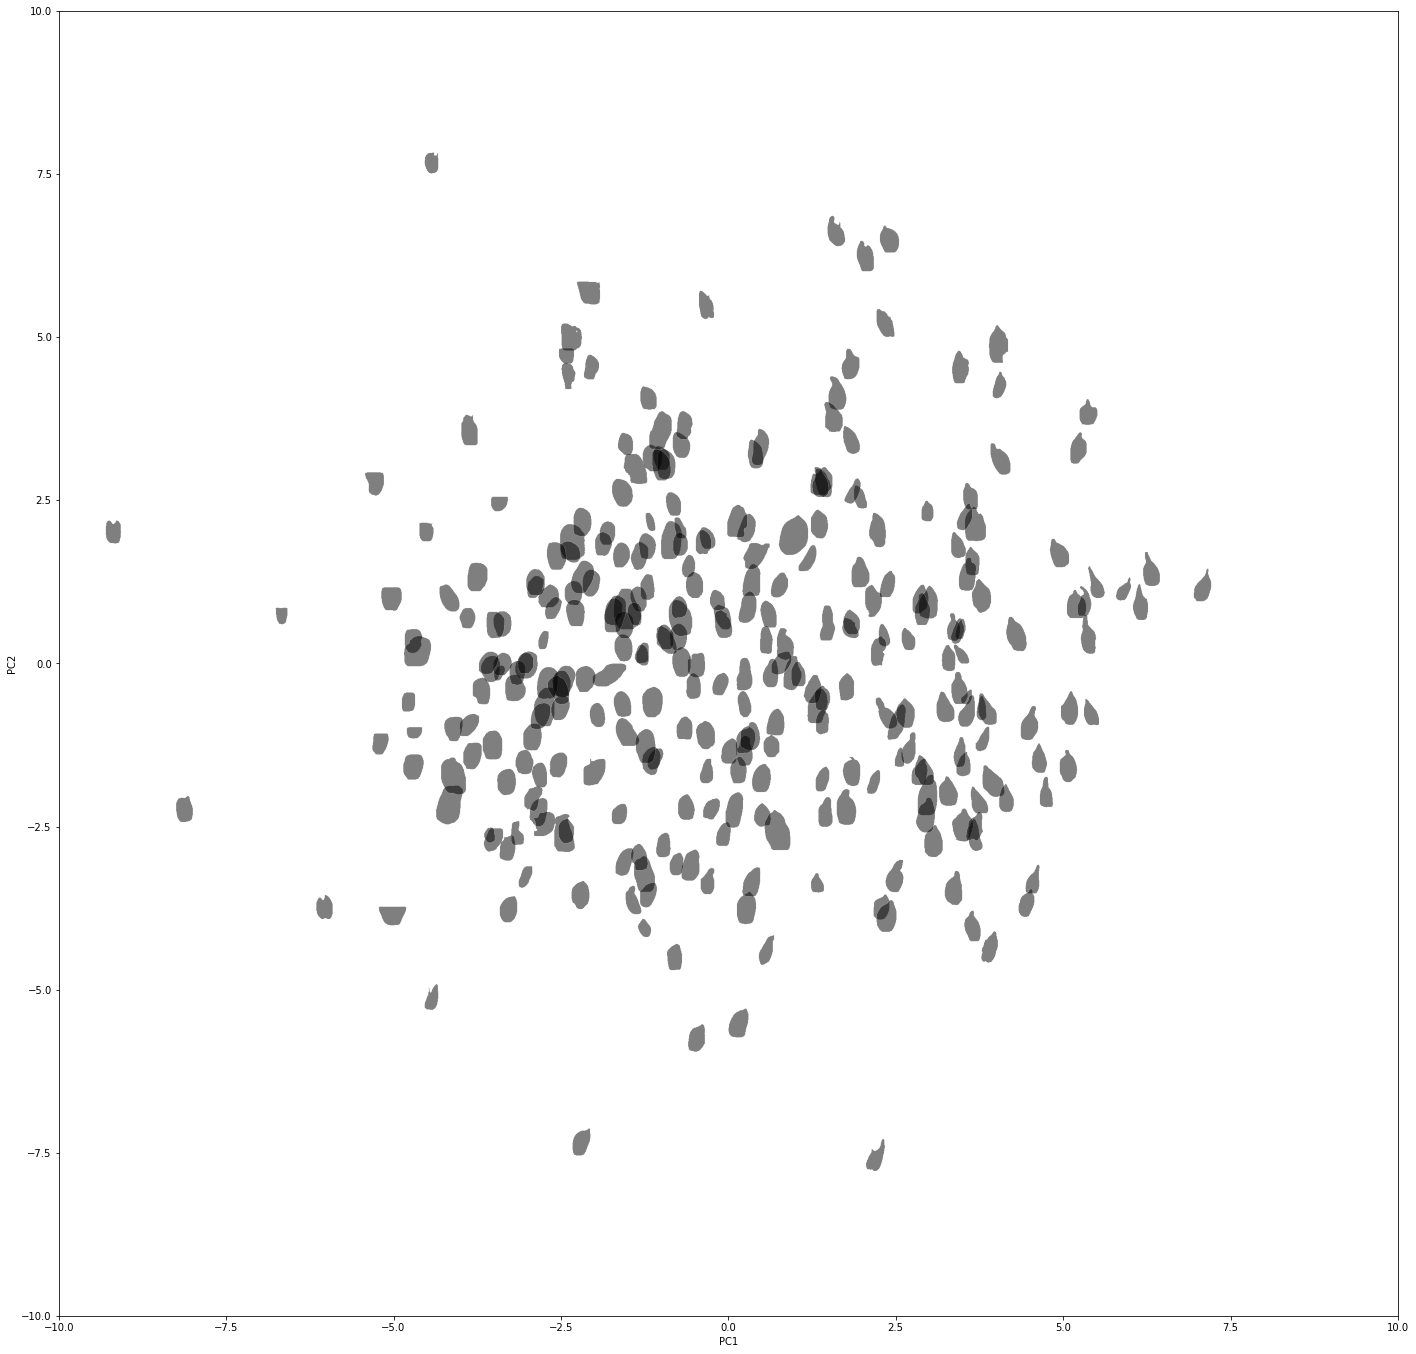

In [5]:
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

# Create plot
fig, ax = plt.subplots(figsize=(24, 24))  # Adjust size as needed

ax.scatter(dfn['PC1'], dfn['PC2'], color='none')  # Use transparent points to mark coordinates

for _, row in dfn.iterrows():
    mask_id = row['mask_id']
    year = row['year']
    if year == 21:
        path = '/work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/experiments/maize_21UM/masks/' + mask_id + '.bmp'
    elif year == 24:
        path = '/work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/experiments/maize_24UM/masks/' + mask_id + '.bmp'
    #if mask_id == 'mask_100':
     #   break
    # Load image, invert colors, and convert to RGBA
    img = Image.open(path)
    img = ImageOps.invert(img).convert("RGBA")

    # Make the white background transparent
    datas = img.getdata()
    new_data = []
    for item in datas:
        # Check if the pixel is near-white or near-black
        if item[0] > 200 and item[1] > 200 and item[2] > 200:  # Near-white
            new_data.append((255, 255, 255, 0))  # Set to transparent
        elif item[0] < 50 and item[1] < 50 and item[2] < 50:  # Near-black
            new_data.append((0, 0, 0, 128))  # Set to transparent
        else:
            new_data.append(item)  # Keep original pixel
    img.putdata(new_data)

    # Get coordinates
    x, y = row['PC1'], row['PC2']

    # Overlay image on the plot with an increased extent range for larger image size
    ax.imshow(img, extent=(x - 1.5, x + 1.5, y - 1.5, y + 1.5), aspect='auto')  # Adjust extent as needed. ,

ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.savefig("CIRCgt1ra3_pistilimgpca3.png", dpi=300, bbox_inches='tight')  # Saves as a PNG with high resolution

plt.show()

In [68]:
df = pd.read_csv('/work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/experiments/maize_24UM/results/joined_df_pre_5_pistil_count_filter.csv')

df = df[df['genotype'] == 'tb1gt1ra3']
df = df.sample(n=300)
df

,Unnamed: 0.1,row_labels,PC1,PC2,PC3,PC4,...1,Unnamed: 0,image_id,planting_date,...,possible_overlap,scan_position,scan_angle,plant_id,total_scans_for_sample,y_pos_all_overlapped,y_pos_all_overlapped_len_standardized,mask_id,year,plant
2230,2231,mask_2012_12,-2.048753,-0.532724,-0.491675,0.558072,2012,10,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,late_planting,...,False,4,8,280-7,8,2724.0,0.450397,mask_2012,24,tb1gt1ra3_280-7
5915,5916,mask_975_12,-0.796543,-0.609345,0.877465,-1.427803,975,0,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,early_planting,...,False,2,8,265-1,6,545.5,0.115859,mask_975,24,tb1gt1ra3_265-1
2516,2517,mask_2141_12,-1.749175,0.242843,-1.496758,-2.069044,2141,5,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,late_planting,...,False,1,8,281-7,8,613.0,0.101356,mask_2141,24,tb1gt1ra3_281-7
2494,2495,mask_2131_12,0.777902,-1.694432,-3.005871,-0.180230,2131,0,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,late_planting,...,False,5,8,281-5,5,1375.0,0.341022,mask_2131,24,tb1gt1ra3_281-5
2709,2710,mask_2229_12,0.591840,4.054676,-1.707123,-0.480411,2229,1,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,late_planting,...,False,1,8,455-3,8,621.0,0.102679,mask_2229,24,tb1gt1ra3_455-3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2918,2919,mask_2323_12,0.354029,-3.012233,-1.881711,0.880948,2323,8,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,late_planting,...,False,3,8,281-2,7,1668.0,0.310268,mask_2323,24,tb1gt1ra3_281-2
2563,2564,mask_2163_12,0.674545,-2.300778,-2.620793,1.496913,2163,2,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,late_planting,...,False,4,8,281-7,8,2771.5,0.458168,mask_2163,24,tb1gt1ra3_281-7
2306,2307,mask_2047_12,4.159182,0.342667,0.112912,1.208915,2047,2,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,late_planting,...,False,4,8,281-10,5,1661.5,0.411954,mask_2047,24,tb1gt1ra3_281-10
5642,5643,mask_851_12,2.030857,0.340710,1.085915,-0.637604,851,3,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,early_planting,...,False,5,8,264-1,8,1561.0,0.258102,mask_851,24,tb1gt1ra3_264-1


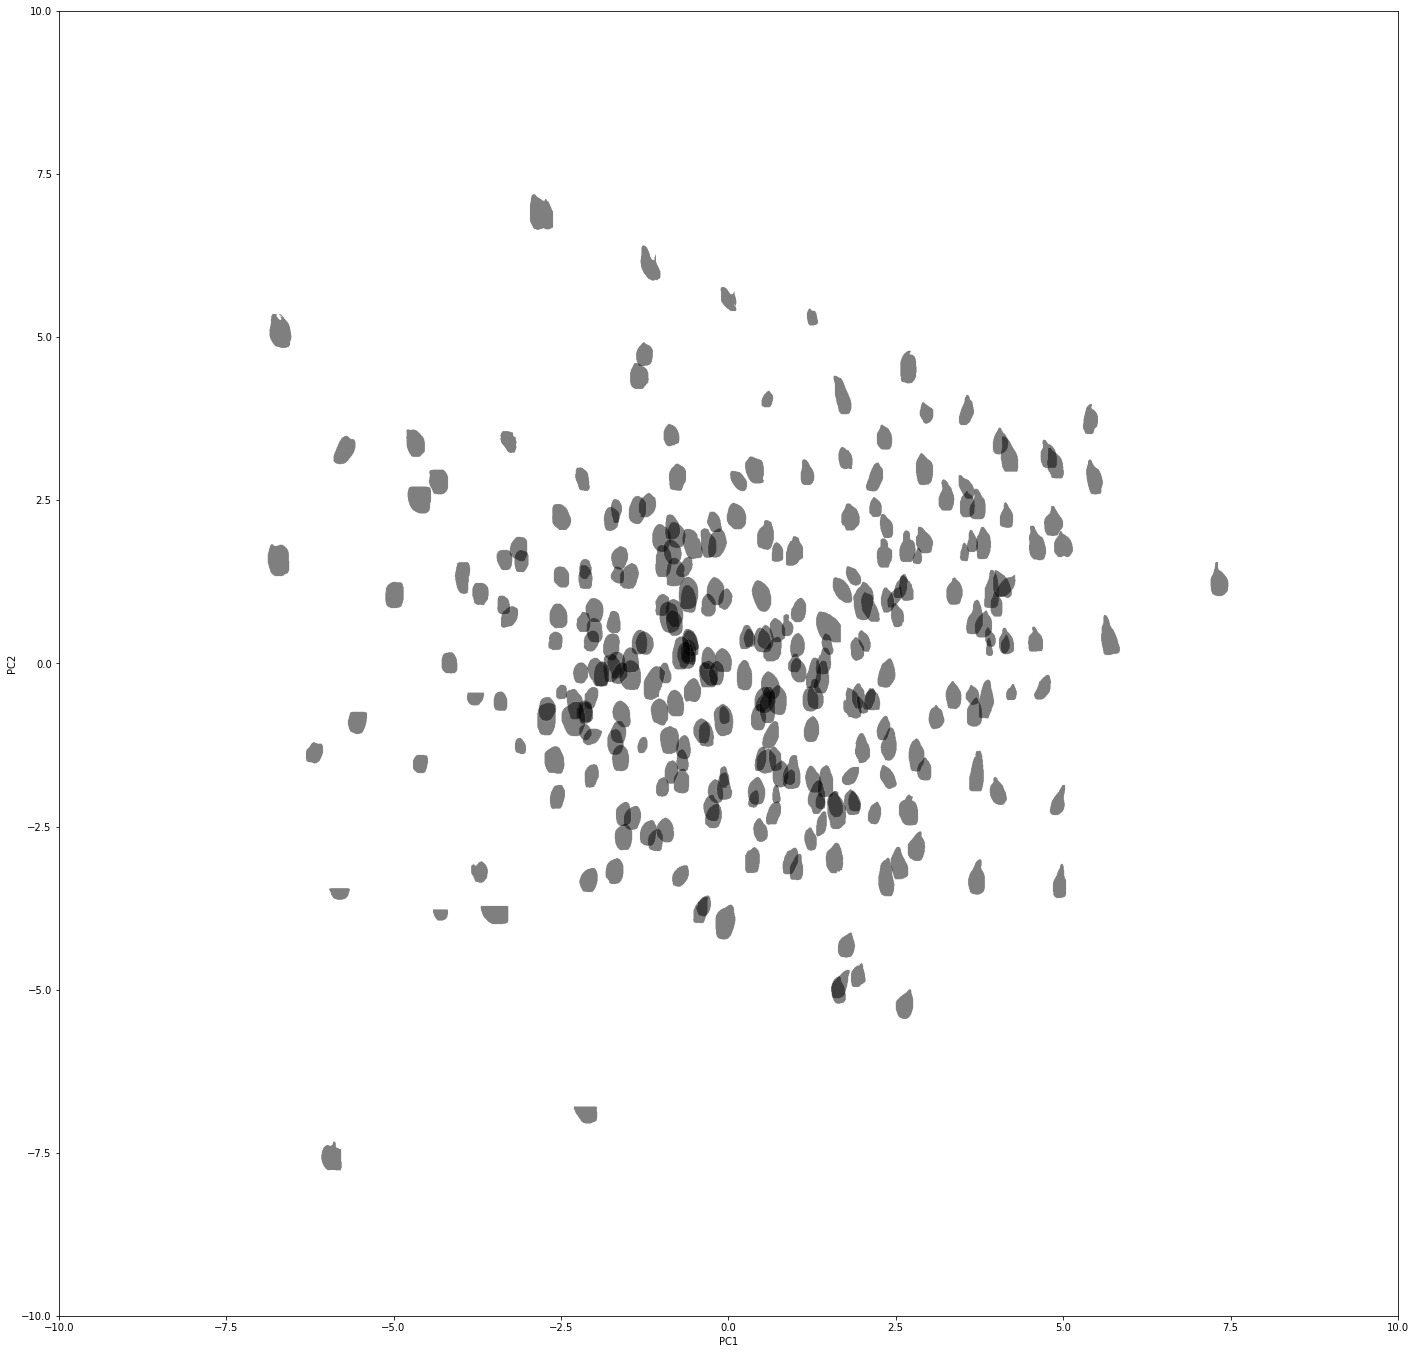

In [70]:
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

# Create plot
fig, ax = plt.subplots(figsize=(24, 24))  # Adjust size as needed

ax.scatter(df['PC1'], df['PC2'], color='none')  # Use transparent points to mark coordinates

for _, row in df.iterrows():
    mask_id = row['mask_id']
    year = row['year']
    if year == 21:
        path = '/work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/experiments/maize_21UM/masks/' + mask_id + '.bmp'
    elif year == 24:
        path = '/work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/experiments/maize_24UM/masks/' + mask_id + '.bmp'
    #if mask_id == 'mask_100':
     #   break
    # Load image, invert colors, and convert to RGBA
    img = Image.open(path)
    img = ImageOps.invert(img).convert("RGBA")

    # Make the white background transparent
    datas = img.getdata()
    new_data = []
    for item in datas:
        # Check if the pixel is near-white or near-black
        if item[0] > 200 and item[1] > 200 and item[2] > 200:  # Near-white
            new_data.append((255, 255, 255, 0))  # Set to transparent
        elif item[0] < 50 and item[1] < 50 and item[2] < 50:  # Near-black
            new_data.append((0, 0, 0, 128))  # Set to transparent
        else:
            new_data.append(item)  # Keep original pixel
    img.putdata(new_data)

    # Get coordinates
    x, y = row['PC1'], row['PC2']

    # Overlay image on the plot with an increased extent range for larger image size
    ax.imshow(img, extent=(x - 1.5, x + 1.5, y - 1.5, y + 1.5), aspect='auto')  # Adjust extent as needed

ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.savefig("tb1gt1ra3_pistilimgpca.png", dpi=300, bbox_inches='tight')  # Saves as a PNG with high resolution

plt.show()

In [3]:
#seeing if we can differentiate weird pistils from normal ones for quantification  #doublepistil step 1
df = pd.read_csv('/work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/experiments/maize_24UM/results/joined_df_pre_5_pistil_count_filter.csv')
#df['pistil_class'] = np.nan
#df['pistil_class_inferred'] = np.nan

In [4]:
df_gt1ra3 = df[df['genotype'] == 'gt1ra3B73']
#df_gt1ra3 = df_gt1ra3.sample(n=300)

In [5]:
df_gt1ra3

,Unnamed: 0.1,row_labels,PC1,PC2,PC3,PC4,...1,Unnamed: 0,image_id,planting_date,...,possible_overlap,scan_position,scan_angle,plant_id,total_scans_for_sample,y_pos_all_overlapped,y_pos_all_overlapped_len_standardized,mask_id,year,plant
6,7,mask_100_1,-0.740394,2.854789,2.370725,2.253109,100,1,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,early_planting,...,False,0,8,154-3,4,351.0,0.104464,mask_100,21,gt1ra3B73_154-3
7,8,mask_100_12,0.630114,-0.155109,-0.215825,2.308115,100,1,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,early_planting,...,False,7,8,266-10,9,4070.0,0.605655,mask_100,24,gt1ra3B73_266-10
8,9,mask_1000_1,5.599471,-0.491715,-0.951967,0.904748,1000,2,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,early_planting,...,False,4,8,158-4,6,2736.5,0.581633,mask_1000,21,gt1ra3B73_158-4
10,11,mask_1001_1,-3.939040,-0.265236,1.163912,-1.828203,1001,4,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,early_planting,...,False,4,8,158-4,6,1794.0,0.381378,mask_1001,21,gt1ra3B73_158-4
12,13,mask_1002_1,1.997847,-3.365089,0.433195,-1.563413,1002,5,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,early_planting,...,False,4,8,158-4,6,2786.5,0.592262,mask_1002,21,gt1ra3B73_158-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5957,5958,mask_995_1,-0.541171,0.640679,-0.330445,-2.705440,995,7,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,early_planting,...,False,3,8,158-4,6,1194.0,0.253827,mask_995,21,gt1ra3B73_158-4
5959,5960,mask_996_1,2.369025,6.497373,-0.588034,0.574079,996,9,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,early_planting,...,False,3,8,158-4,6,2226.0,0.473214,mask_996,21,gt1ra3B73_158-4
5961,5962,mask_997_1,2.708181,-1.372224,-1.870695,0.052119,997,10,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,early_planting,...,False,3,8,158-4,6,1542.0,0.327806,mask_997,21,gt1ra3B73_158-4
5963,5964,mask_998_1,0.730174,3.747580,0.937258,2.531282,998,12,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,early_planting,...,False,3,8,158-4,6,1558.0,0.331207,mask_998,21,gt1ra3B73_158-4


In [ ]:
y=0
for x in df_gt1ra3['image_id']:
    print(y)
    if 'maize_21UM_data' in x :
        show_image_with_and_without_bboxes(x,df_gt1ra3, update_path(x))
    else:
        show_image_with_and_without_bboxes(x,df_gt1ra3, x)
    y=y+1

<Figure size 576x432 with 0 Axes>

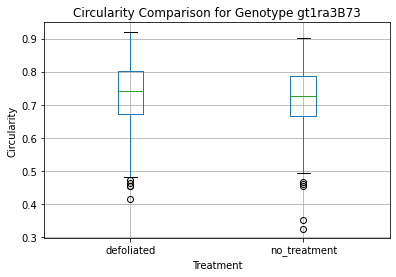

In [24]:
#gt1ra3 defolaitaion circularity diff
# Filter the data for the genotype of interest
genotype_of_interest = 'gt1ra3B73'
filtered_df1 = df[df['genotype'] == genotype_of_interest]
filtered_df = filtered_df1[filtered_df1['year'] == 24]
# Plot boxplot of circularity for untreated and treated groups
plt.figure(figsize=(8, 6))
filtered_df.boxplot(column='pistil_circularity', by='treatment')

# Customize plot
plt.title(f'Circularity Comparison for Genotype {genotype_of_interest}')
plt.suptitle('')  # Remove default boxplot title
plt.xlabel('Treatment')
plt.ylabel('Circularity')
plt.show()



In [25]:
import pandas as pd
from scipy.stats import ttest_ind
#filtered_df = df[df['genotype'] == genotype_of_interest]

# Separate circularity values by treatment group
untreated = filtered_df[filtered_df['treatment'] == 'no_treatment']['pistil_circularity']
treated = filtered_df[filtered_df['treatment'] == 'defoliated']['pistil_circularity']

# Perform t-test
t_stat, p_value = ttest_ind(untreated, treated, equal_var=False)  # Use equal_var=False for Welch's t-test

# Display results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: -2.1088074519593363
P-value: 0.035174987634432726


In [ ]:
#overall goal:data is stored in a dataframe, for a given image with segmentation data, find the size difference between pistil pairs

#steps: for a given image in the dataframe, iterate over the pistils and find the pistils that have exactly 1 overlap

#for the pistils that have 1 overlap, store the name of the pistil that is the overlap partner

#for pistils that have matching overlap partners, those are a pair. disgard any other pistils.

#for each pistil pair in the image, for the pistil with the bigger area, classify that as bigger_of_pair, and for the smaller one, classify that as smaller_of_pair. this is in a new column called "floret_pairs". Some values will be NA in the column for pistils that are not a pair

#calculate a "pair size difference", what is the area difference between the bigger_of_pair and smaller_of_pair? Just calculate this value for all the bigger_of_pair pistils

In [ ]:
import pandas as pd
import numpy as np

# Sample DataFrame
# df = pd.read_csv('your_dataframe.csv')  # Load your actual data

# Function to identify pairs based on overlap and area
def identify_pistil_pairs(df):
    df['overlap_partner'] = None  # New column to store overlap partners

    # Iterate over unique images
    for image_id, group in df.groupby('image_id'):
        # Assume a function exists to find overlaps based on bbox and segm
        for i, row_i in group.iterrows():
            overlaps = []
            for j, row_j in group.iterrows():
                if i != j and has_single_overlap(row_i['segm'], row_j['segm']):
                    overlaps.append(row_j['pistil_id'])

            # Keep only pistils with exactly one overlap partner
            if len(overlaps) == 1:
                df.at[i, 'overlap_partner'] = overlaps[0]

    # Filter to find valid pairs
    df['is_pair'] = df.apply(lambda x: x['pistil_id'] in df[df['overlap_partner'] == x['pistil_id']]['pistil_id'].values, axis=1)
    
    # Classify pistils as bigger or smaller in pairs
    df['floret_pairs'] = None
    for image_id, group in df[df['is_pair']].groupby('image_id'):
        for _, row in group.iterrows():
            partner = df[(df['image_id'] == image_id) & (df['pistil_id'] == row['overlap_partner'])]
            if not partner.empty:
                if row['pistil_area'] > partner.iloc[0]['pistil_area']:
                    df.at[row.name, 'floret_pairs'] = 'bigger_of_pair'
                    df.at[partner.index[0], 'floret_pairs'] = 'smaller_of_pair'
                else:
                    df.at[row.name, 'floret_pairs'] = 'smaller_of_pair'
                    df.at[partner.index[0], 'floret_pairs'] = 'bigger_of_pair'

    # Calculate pair size difference
    df['pair_size_difference'] = np.where(df['floret_pairs'] == 'bigger_of_pair', 
                                          df['pistil_area'] - df['pistil_area'].shift(-1),  
                                          np.nan)
    return df

# Placeholder for actual overlap check logic
def has_single_overlap(segm1, segm2):
    # Implement your logic to check if segm1 and segm2 have exactly one overlap
    return False  # Replace with real condition

# Run the function on your DataFrame
# df = identify_pistil_pairs(df)
# print(df.head())  # Verify the output


In [7]:
df

,Unnamed: 0,image_id,planting_date,genotype,treatment,pistil_area,pistil_circularity,bbox,segm,confidence,...,center_y,perimeter_intersect,possible_overlap,scan_position,scan_angle,plant_id,total_scans_for_sample,y_pos_all_overlapped,y_pos_all_overlapped_len_standardized,overlap_partner
0,0.0,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,early_planting,b73,no_treatment,146,0.8654885686631225,[[410.5882 295.3388 426.31854 311.68604]],"{'size': [672, 1008], 'counts': b'\\P^81ld05N2...",0.9403938,...,368.5,False,False,02,08,_275-5,05,839.5,0.20808531746031747,None
1,0.0,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,early_planting,b73,no_treatment,108,0.9048680065789002,[[400.78745 312.7289 410.93314 329.1174 ]],"{'size': [672, 1008], 'counts': b'Q_W84id05M2M...",0.9594597,...,351.0,False,False,04,08,_275-5,05,1489.0,0.36929563492063494,None
2,0.0,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,early_planting,b73,no_treatment,1366,0.7275947557640956,[[475.69516 167.55325 505.56458 229.67683]],"{'size': [672, 1008], 'counts': b'`Vi9P1oc08H5...",0.94697165,...,473.0,False,False,02,08,_275_3,03,1153.0,0.4289434523809524,None
3,0.0,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,early_planting,b73,no_treatment,1164,0.8508898377209779,[[510.83582 0. 548.4175 39.570732]],"{'size': [672, 1008], 'counts': b'W[_:i0Rd08L2...",0.8827472,...,653.5,True,False,00,08,_275_7,00,653.5,0.9717261904761905,None
4,0.0,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,early_planting,b73,no_treatment,973,0.7086425875393162,[[512.0882 159.58313 533.6663 217.12825]],"{'size': [672, 1008], 'counts': b'iU`:=\\d0>B;...",0.89538884,...,484.5,False,False,02,08,_275_9,02,1187.5,0.5887896825396826,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2462,0.0,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,late_planting,tb1,no_treatment,1476,0.7163430364293106,[[508.45453 75.70345 543.8718 136.99603]],"{'size': [672, 1008], 'counts': b'bT^:`0\\d06J...",0.9144739,...,566.5,False,False,06,08,_288-3,07,3699.5,0.6880580357142857,None
2463,1.0,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,late_planting,tb1,no_treatment,929,0.8406893441747576,[[505.83975 369.59775 537.69574 411.3391 ]],"{'size': [672, 1008], 'counts': b'm]\\:<ad0302...",0.8985962,...,282.0,False,False,06,08,_288-3,07,1708.0,0.3177083333333333,None
2464,0.0,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,late_planting,tb1,no_treatment,926,0.6709023254124531,[[326.147 101.974335 347.191 157.53622 ]],"{'size': [672, 1008], 'counts': b'Qgf6e0Qd0=G8...",0.9284745,...,542.0,False,False,00,08,_288-6,00,542.0,0.8065476190476191,None
2465,0.0,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,late_planting,tb1,no_treatment,122,0.9970227262730132,[[462.973 191.71713 477.23145 205.84348]],"{'size': [672, 1008], 'counts': b'Rf`94kd03N2M...",0.96883225,...,474.0,False,False,06,08,_288-9,07,3052.0,0.5677083333333334,None


In [29]:
import pandas as pd
import numpy as np
from itertools import combinations

# Sample DataFrame
# df = pd.read_csv('your_dataframe.csv')  # Load your actual data

# Function to identify pairs based on overlap and area
def identify_pistil_pairs(df):
    df['overlap_partner'] = None  # New column to store overlap partners

    # Iterate over unique images
    for image_id, group in df.groupby('image_id'):
        # Extract bounding boxes
        bboxes = group['bbox'].tolist()
        bbox_arrays = []
        for bbox_entry in bboxes:
            bbox_array = get_bounding_box_array(bbox_entry)
            if bbox_array is not None:
                bbox_arrays.append(bbox_array)

        # Check for pairs with exactly two overlaps
        for bbox_pair in combinations(bbox_arrays, 2):
            bbox1, bbox2 = bbox_pair
            intersection_area = compute_intersection_area(bbox1, bbox2)
            if intersection_area > 0:
                # Find the corresponding rows
                indices = group[(group['bbox'].apply(lambda x: get_bounding_box_array(x) == bbox1)) | 
                                (group['bbox'].apply(lambda x: get_bounding_box_array(x) == bbox2))].index
                if len(indices) == 2:
                    df.at[indices[0], 'overlap_partner'] = group.at[indices[1], 'row_labels']
                    df.at[indices[1], 'overlap_partner'] = group.at[indices[0], 'row_labels']

    # Filter to find valid pairs
    df['is_pair'] = df.apply(lambda x: x['row_labels'] in df[df['overlap_partner'] == x['row_labels']]['row_labels'].values, axis=1)
    
    # Classify pistils as bigger or smaller in pairs
    df['floret_pairs'] = None
    for image_id, group in df[df['is_pair']].groupby('image_id'):
        for _, row in group.iterrows():
            partner = df[(df['image_id'] == image_id) & (df['row_labels'] == row['overlap_partner'])]
            if not partner.empty:
                if row['pistil_area'] > partner.iloc[0]['pistil_area']:
                    df.at[row.name, 'floret_pairs'] = 'bigger_of_pair'
                    df.at[partner.index[0], 'floret_pairs'] = 'smaller_of_pair'
                else:
                    df.at[row.name, 'floret_pairs'] = 'smaller_of_pair'
                    df.at[partner.index[0], 'floret_pairs'] = 'bigger_of_pair'

    # Calculate pair size difference
    df['pair_size_difference'] = np.where(df['floret_pairs'] == 'bigger_of_pair', 
                                          df['pistil_area'] - df['pistil_area'].shift(-1),  
                                          np.nan)
    return df

# Function to get bounding box array
def get_bounding_box_array(bbox_entry):
    if isinstance(bbox_entry, str):
        if "bbox" in bbox_entry or not any(char.isdigit() for char in bbox_entry):
            return None
        bbox_str = bbox_entry.strip('[]')
        numbers = bbox_str.replace(',', ' ').split()
        try:
            return [float(num) for num in numbers]
        except ValueError:
            return None
    elif isinstance(bbox_entry, (list, tuple, np.ndarray)):
        if all(isinstance(num, (int, float)) for num in bbox_entry):
            return list(bbox_entry)
        else:
            return None
    elif isinstance(bbox_entry, dict):
        keys = ['x1', 'y1', 'x2', 'y2']
        try:
            return [float(bbox_entry[key]) for key in keys]
        except (KeyError, ValueError):
            return None
    else:
        return None

# Function to compute intersection area
def compute_intersection_area(bbox1, bbox2):
    x_left = max(bbox1[0], bbox2[0])
    y_top = max(bbox1[1], bbox2[1])
    x_right = min(bbox1[2], bbox2[2])
    y_bottom = min(bbox1[3], bbox2[3])

    if x_right <= x_left or y_bottom <= y_top:
        return 0.0
    else:
        return (x_right - x_left) * (y_bottom - y_top)

# Run the function on your DataFrame
df = identify_pistil_pairs(df_gt1ra3)
print(df_gt1ra3.head())  # Verify the output

    Unnamed: 0.1   row_labels       PC1       PC2       PC3       PC4  ...1  \
6              7   mask_100_1 -0.740394  2.854789  2.370725  2.253109   100   
7              8  mask_100_12  0.630114 -0.155109 -0.215825  2.308115   100   
8              9  mask_1000_1  5.599471 -0.491715 -0.951967  0.904748  1000   
10            11  mask_1001_1 -3.939040 -0.265236  1.163912 -1.828203  1001   
12            13  mask_1002_1  1.997847 -3.365089  0.433195 -1.563413  1002   

    Unnamed: 0                                           image_id  \
6            1  /work/pi_mbartlett_umass_edu/AmberDeNeve/grass...   
7            1  /work/pi_mbartlett_umass_edu/AmberDeNeve/grass...   
8            2  /work/pi_mbartlett_umass_edu/AmberDeNeve/grass...   
10           4  /work/pi_mbartlett_umass_edu/AmberDeNeve/grass...   
12           5  /work/pi_mbartlett_umass_edu/AmberDeNeve/grass...   

     planting_date  ... total_scans_for_sample y_pos_all_overlapped  \
6   early_planting  ...                

In [71]:
def identify_pistil_pairs(df):
    df['overlap_partner'] = None  # New column to store overlap partners
    # Iterate over unique images
    for image_id, group in df.groupby('image_id'):
        # Extract bounding boxes
        print("this is group ", group)
        bboxes = group['bbox'].tolist()
        bbox_arrays = []
        for bbox_entry in bboxes:
            bbox_array = get_bounding_box_array(bbox_entry)
            if bbox_array is not None:
                bbox_arrays.append(bbox_array)
        

        # Check for pairs with exactly two overlaps
        for bbox_pair in combinations(bbox_arrays, 2):
                bbox1, bbox2 = bbox_pair
                intersection_area = compute_intersection_area(bbox1, bbox2)
                print(intersection_area)
                if intersection_area > 0:
                    # Find the corresponding rows
                    indices = group[(group['bbox'].apply(lambda x: get_bounding_box_array(x) == bbox1)) | 
                                (group['bbox'].apply(lambda x: get_bounding_box_array(x) == bbox2))].index
                    print(indices)
                    if len(indices) == 2:
                        print("checkpoint")
                        df.at[indices[0], 'overlap_partner'] = group.at[indices[1], 'row_labels']
                        df.at[indices[1], 'overlap_partner'] = group.at[indices[0], 'row_labels']

        # Filter to find valid pairs
        # Filter to find valid pairs
    df['is_pair'] = False  # Initialize the column with False
    for i, row in df.iterrows():
        # Check if the current row's 'row_labels' is in another row's 'overlap_partner'
        overlap_partner = row['overlap_partner']
        if pd.notnull(overlap_partner):
            partner_row = df[(df['row_labels'] == overlap_partner) & (df['overlap_partner'] == row['row_labels'])]
            if not partner_row.empty:
                df.at[i, 'is_pair'] = True
    # Classify pistils as bigger or smaller in pairs
    df['floret_pairs'] = None
    for image_id, group in df[df['is_pair']].groupby('image_id'):
        for _, row in group.iterrows():
            partner = df[(df['image_id'] == image_id) & (df['row_labels'] == row['overlap_partner'])]
            if not partner.empty:
                if row['pistil_area'] > partner.iloc[0]['pistil_area']:
                    df.at[row.name, 'floret_pairs'] = 'bigger_of_pair'
                    df.at[partner.index[0], 'floret_pairs'] = 'smaller_of_pair'
                else:
                    df.at[row.name, 'floret_pairs'] = 'smaller_of_pair'
                    df.at[partner.index[0], 'floret_pairs'] = 'bigger_of_pair'

    # Calculate pair size difference
    # Calculate pair size difference based on the actual partner
    df['pair_size_difference'] = np.nan  # Initialize with NaN

    for _, row in df[df['floret_pairs'] == 'bigger_of_pair'].iterrows():
        partner_index = df[(df['image_id'] == row['image_id']) & 
                       (df['row_labels'] == row['overlap_partner'])].index
        if not partner_index.empty:
            partner_area = df.at[partner_index[0], 'pistil_area']
            size_difference = row['pistil_area'] - partner_area
            df.at[row.name, 'pair_size_difference'] = size_difference
    return df
    


In [ ]:
import pandas as pd
import numpy as np
from itertools import combinations

# Sample DataFrame
# df = pd.read_csv('your_dataframe.csv')  # Load your actual data
def identify_pistil_pair(df):
    df['overlap_partner'] = None  # New column to store overlap partners
    df['pair_id'] = None  # New column to store unique pair IDs
    pair_counter = 1  # Initialize pair ID counter

    # Iterate over unique images
    for image_id, group in df.groupby('image_id'):
        # Extract bounding boxes
        bboxes = group['bbox'].tolist()
        bbox_arrays = []
        for bbox_entry in bboxes:
            bbox_array = get_bounding_box_array(bbox_entry)
            if bbox_array is not None:
                bbox_arrays.append(bbox_array)

        # Check for pairs with exactly two overlaps
        for bbox_pair in combinations(bbox_arrays, 2):
            bbox1, bbox2 = bbox_pair
            intersection_area = compute_intersection_area(bbox1, bbox2)
            if intersection_area > 0:
                # Find the corresponding rows
                indices = group[(group['bbox'].apply(lambda x: get_bounding_box_array(x) == bbox1)) | 
                                (group['bbox'].apply(lambda x: get_bounding_box_array(x) == bbox2))].index
                if len(indices) == 2:
                    df.at[indices[0], 'overlap_partner'] = group.at[indices[1], 'row_labels']
                    df.at[indices[1], 'overlap_partner'] = group.at[indices[0], 'row_labels']

                    # Assign the same pair ID to both pistils
                    df.at[indices[0], 'pair_id'] = pair_counter
                    df.at[indices[1], 'pair_id'] = pair_counter

                    # Increment the pair counter for the next pair
                    pair_counter += 1

    # Filter to find valid pairs
    df['is_pair'] = False  # Initialize the column with False
    for i, row in df.iterrows():
        # Check if the current row's 'row_labels' is in another row's 'overlap_partner'
        overlap_partner = row['overlap_partner']
        if pd.notnull(overlap_partner):
            partner_row = df[(df['row_labels'] == overlap_partner) & (df['overlap_partner'] == row['row_labels'])]
            if not partner_row.empty:
                df.at[i, 'is_pair'] = True

    # Classify pistils as bigger or smaller in pairs
    df['floret_pairs'] = None
    for image_id, group in df[df['is_pair']].groupby('image_id'):
        for _, row in group.iterrows():
            partner = df[(df['image_id'] == image_id) & (df['row_labels'] == row['overlap_partner'])]
            if not partner.empty:
                if row['pistil_area'] > partner.iloc[0]['pistil_area']:
                    df.at[row.name, 'floret_pairs'] = 'bigger_of_pair'
                    df.at[partner.index[0], 'floret_pairs'] = 'smaller_of_pair'
                else:
                    df.at[row.name, 'floret_pairs'] = 'smaller_of_pair'
                    df.at[partner.index[0], 'floret_pairs'] = 'bigger_of_pair'

    # Calculate pair size difference based on the actual partner
    df['pair_size_difference'] = np.nan  # Initialize with NaN

    for _, row in df[df['floret_pairs'] == 'bigger_of_pair'].iterrows():
        partner_index = df[(df['image_id'] == row['image_id']) & 
                           (df['row_labels'] == row['overlap_partner'])].index
        if not partner_index.empty:
            partner_area = df.at[partner_index[0], 'pistil_area']
            size_difference = row['pistil_area'] - partner_area
            df.at[row.name, 'pair_size_difference'] = size_difference
    
    return df

# Function to identify pairs based on overlap and area
def identify_pistil_pairs(df):
    df['overlap_partner'] = None  # New column to store overlap partners

    # Iterate over unique images
    for image_id, group in df.groupby('image_id'):
        # Extract bounding boxes
        print("this is group ", group)
        bboxes = group['bbox'].tolist()
        bbox_arrays = []
        for bbox_entry in bboxes:
            bbox_array = get_bounding_box_array(bbox_entry)
            if bbox_array is not None:
                bbox_arrays.append(bbox_array)

        # Check for pairs with exactly two overlaps
        for bbox_pair in combinations(bbox_arrays, 2):
            bbox1, bbox2 = bbox_pair
            intersection_area = compute_intersection_area(bbox1, bbox2)
            print(intersection_area)
            if intersection_area > 0:
                # Find the corresponding rows
                indices = group[(group['bbox'].apply(lambda x: get_bounding_box_array(x) == bbox1)) | 
                                (group['bbox'].apply(lambda x: get_bounding_box_array(x) == bbox2))].index
                print(indices)
                if len(indices) == 2:
                    print("checkpoint")
                    df.at[indices[0], 'overlap_partner'] = group.at[indices[1], 'row_labels']
                    df.at[indices[1], 'overlap_partner'] = group.at[indices[0], 'row_labels']

    # Filter to find valid pairs
    df['is_pair'] = False  # Initialize the column with False
    for i, row in df.iterrows():
        # Check if the current row's 'row_labels' is in another row's 'overlap_partner'
        overlap_partner = row['overlap_partner']
        if pd.notnull(overlap_partner):
            partner_row = df[(df['row_labels'] == overlap_partner) & (df['overlap_partner'] == row['row_labels'])]
            if not partner_row.empty:
                df.at[i, 'is_pair'] = True

    # Classify pistils as bigger or smaller in pairs
    df['floret_pairs'] = None
    for image_id, group in df[df['is_pair']].groupby('image_id'):
        for _, row in group.iterrows():
            partner = df[(df['image_id'] == image_id) & (df['row_labels'] == row['overlap_partner'])]
            if not partner.empty:
                if row['pistil_area'] > partner.iloc[0]['pistil_area']:
                    df.at[row.name, 'floret_pairs'] = 'bigger_of_pair'
                    df.at[partner.index[0], 'floret_pairs'] = 'smaller_of_pair'
                else:
                    df.at[row.name, 'floret_pairs'] = 'smaller_of_pair'
                    df.at[partner.index[0], 'floret_pairs'] = 'bigger_of_pair'

    # Calculate pair size difference based on the actual partner
    df['pair_size_difference'] = np.nan  # Initialize with NaN

    for _, row in df[df['floret_pairs'] == 'bigger_of_pair'].iterrows():
        partner_index = df[(df['image_id'] == row['image_id']) & 
                           (df['row_labels'] == row['overlap_partner'])].index
        if not partner_index.empty:
            partner_area = df.at[partner_index[0], 'pistil_area']
            size_difference = row['pistil_area'] - partner_area
            df.at[row.name, 'pair_size_difference'] = size_difference
    
    return df

# Function to get bounding box array
def get_bounding_box_array(bbox_entry):
    if isinstance(bbox_entry, str):
        if "bbox" in bbox_entry or not any(char.isdigit() for char in bbox_entry):
            return None
        bbox_str = bbox_entry.strip('[]')
        numbers = bbox_str.replace(',', ' ').split()
        try:
            return [float(num) for num in numbers]
        except ValueError:
            return None
    elif isinstance(bbox_entry, (list, tuple, np.ndarray)):
        if all(isinstance(num, (int, float)) for num in bbox_entry):
            return list(bbox_entry)
        else:
            return None
    elif isinstance(bbox_entry, dict):
        keys = ['x1', 'y1', 'x2', 'y2']
        try:
            return [float(bbox_entry[key]) for key in keys]
        except (KeyError, ValueError):
            return None
    else:
        return None

# Function to compute intersection area
def compute_intersection_area(bbox1, bbox2):
    x_left = max(bbox1[0], bbox2[0])
    y_top = max(bbox1[1], bbox2[1])
    x_right = min(bbox1[2], bbox2[2])
    y_bottom = min(bbox1[3], bbox2[3])

    if x_right <= x_left or y_bottom <= y_top:
        return 0.0
    else:
        return (x_right - x_left) * (y_bottom - y_top)

# Run the function on your DataFrame
df = identify_pistil_pair(df_gt1ra3)
# print(df.head())  # Verify the output


In [41]:
import pandas as pd
import numpy as np
from itertools import combinations

# Sample DataFrame
# df = pd.read_csv('your_dataframe.csv')  # Load your actual data

def identify_pistil_pairs(df):
    df['overlap_partner'] = None  # New column to store overlap partners
    df['pair_id'] = None  # New column to store unique pair IDs
    df['overlap_count'] = 0  # New column to store the number of overlaps
    pair_counter = 1  # Initialize pair ID counter

    # Iterate over unique images
    for image_id, group in df.groupby('image_id'):
        # Extract bounding boxes
        bboxes = group['bbox'].tolist()
        bbox_arrays = []
        for bbox_entry in bboxes:
            bbox_array = get_bounding_box_array(bbox_entry)
            if bbox_array is not None:
                bbox_arrays.append(bbox_array)

        # Check for pairs with exactly two overlaps
        for bbox_pair in combinations(bbox_arrays, 2):
            bbox1, bbox2 = bbox_pair
            intersection_area = compute_intersection_area(bbox1, bbox2)
            if intersection_area > 0:
                # Find the corresponding rows
                indices = group[(group['bbox'].apply(lambda x: get_bounding_box_array(x) == bbox1)) | 
                                (group['bbox'].apply(lambda x: get_bounding_box_array(x) == bbox2))].index
                if len(indices) == 2:
                    df.at[indices[0], 'overlap_partner'] = group.at[indices[1], 'row_labels']
                    df.at[indices[1], 'overlap_partner'] = group.at[indices[0], 'row_labels']

                    # Increment overlap counts
                    df.at[indices[0], 'overlap_count'] += 1
                    df.at[indices[1], 'overlap_count'] += 1

                    # Assign the same pair ID to both pistils
                    df.at[indices[0], 'pair_id'] = pair_counter
                    df.at[indices[1], 'pair_id'] = pair_counter

                    # Increment the pair counter for the next pair
                    pair_counter += 1

    # Filter to find valid pairs
    df['is_pair'] = False  # Initialize the column with False
    for i, row in df.iterrows():
        # Check if the current row's 'row_labels' is in another row's 'overlap_partner'
        overlap_partner = row['overlap_partner']
        if pd.notnull(overlap_partner):
            partner_row = df[(df['row_labels'] == overlap_partner) & (df['overlap_partner'] == row['row_labels'])]
            if not partner_row.empty:
                df.at[i, 'is_pair'] = True

    # Classify pistils as bigger or smaller in pairs
    df['floret_pairs'] = None
    for image_id, group in df[df['is_pair']].groupby('image_id'):
        for _, row in group.iterrows():
            partner = df[(df['image_id'] == image_id) & (df['row_labels'] == row['overlap_partner'])]
            if not partner.empty:
                if row['pistil_area'] > partner.iloc[0]['pistil_area']:
                    df.at[row.name, 'floret_pairs'] = 'bigger_of_pair'
                    df.at[partner.index[0], 'floret_pairs'] = 'smaller_of_pair'
                else:
                    df.at[row.name, 'floret_pairs'] = 'smaller_of_pair'
                    df.at[partner.index[0], 'floret_pairs'] = 'bigger_of_pair'

    # Calculate pair size difference based on the actual partner
    df['pair_size_difference'] = np.nan  # Initialize with NaN

    for _, row in df[df['floret_pairs'] == 'bigger_of_pair'].iterrows():
        partner_index = df[(df['image_id'] == row['image_id']) & 
                           (df['row_labels'] == row['overlap_partner'])].index
        if not partner_index.empty:
            partner_area = df.at[partner_index[0], 'pistil_area']
            size_difference = row['pistil_area'] - partner_area
            df.at[row.name, 'pair_size_difference'] = size_difference
    
    return df

# Function to get bounding box array
def get_bounding_box_array(bbox_entry):
    if isinstance(bbox_entry, str):
        if "bbox" in bbox_entry or not any(char.isdigit() for char in bbox_entry):
            return None
        bbox_str = bbox_entry.strip('[]')
        numbers = bbox_str.replace(',', ' ').split()
        try:
            return [float(num) for num in numbers]
        except ValueError:
            return None
    elif isinstance(bbox_entry, (list, tuple, np.ndarray)):
        if all(isinstance(num, (int, float)) for num in bbox_entry):
            return list(bbox_entry)
        else:
            return None
    elif isinstance(bbox_entry, dict):
        keys = ['x1', 'y1', 'x2', 'y2']
        try:
            return [float(bbox_entry[key]) for key in keys]
        except (KeyError, ValueError):
            return None
    else:
        return None

# Function to compute intersection area
def compute_intersection_area(bbox1, bbox2):
    x_left = max(bbox1[0], bbox2[0])
    y_top = max(bbox1[1], bbox2[1])
    x_right = min(bbox1[2], bbox2[2])
    y_bottom = min(bbox1[3], bbox2[3])

    if x_right <= x_left or y_bottom <= y_top:
        return 0.0
    else:
        return (x_right - x_left) * (y_bottom - y_top)

# Run the function on your DataFrame
df = identify_pistil_pairs(df_gt1ra3)
# print(df.head())  # Verify the output

In [42]:
df['overlap_partner']

6        mask_105_1
7              None
8              None
10      mask_1003_1
12       mask_999_1
           ...     
5957           None
5959     mask_993_1
5961     mask_998_1
5963     mask_997_1
5965    mask_1002_1
Name: overlap_partner, Length: 4450, dtype: object

In [55]:
value_counts = df['floret_pairs'].value_counts()
print(value_counts)
value_counts = df['overlap_count'].value_counts()
print(value_counts)


floret_pairs
smaller_of_pair    1128
bigger_of_pair     1128
Name: count, dtype: int64
overlap_count
1    2481
0    1775
2     179
3      15
Name: count, dtype: int64


In [50]:
for i, row in df.iterrows():
    if row['overlap_count'] != 1:
        pair_id = row['pair_id']
        if pd.notnull(pair_id):
            # Update all rows with the same pair_id
            df.loc[df['pair_id'] == pair_id, 'is_pair'] = False
            df.loc[df['pair_id'] == pair_id, 'floret_pairs'] = None
            df.loc[df['pair_id'] == pair_id, 'pair_size_difference'] = np.nan
df[df['overlap_count'] == 2]

,Unnamed: 0.1,row_labels,PC1,PC2,PC3,PC4,...1,Unnamed: 0,image_id,planting_date,...,y_pos_all_overlapped_len_standardized,mask_id,year,plant,overlap_partner,pair_id,is_pair,floret_pairs,pair_size_difference,overlap_count
38,39,mask_1014_1,0.936828,-1.854926,2.599148,-0.770017,1014,2,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,early_planting,...,0.436650,mask_1014,21,gt1ra3B73_158-4,mask_1016_1,368,False,None,NaN,2
76,77,mask_1032_1,3.783745,1.032986,-2.282446,1.471493,1032,8,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,early_planting,...,0.177827,mask_1032,21,gt1ra3B73_158-6,mask_1034_1,377,False,None,NaN,2
80,81,mask_1034_1,-3.667915,-0.276766,-2.115518,-1.063125,1034,12,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,early_planting,...,0.160466,mask_1034,21,gt1ra3B73_158-6,mask_1035_1,378,False,None,NaN,2
238,239,mask_1106_12,-5.208321,5.326696,5.287799,6.706398,1106,7,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,late_planting,...,0.448082,mask_1106,24,gt1ra3B73_282-2,mask_1105_12,1234,False,None,NaN,2
256,257,mask_1114_12,-0.850477,4.511605,0.968884,0.265382,1114,1,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,late_planting,...,0.058929,mask_1114,24,gt1ra3B73_282-4,mask_1117_12,1239,False,None,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5765,5766,mask_907_1,1.007823,-3.456853,1.404755,-1.575727,907,10,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,early_planting,...,0.198847,mask_907,21,gt1ra3B73_158-2,mask_911_1,336,False,None,NaN,2
5781,5782,mask_914_1,-0.987402,2.926151,-1.505845,-0.374479,914,27,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,early_planting,...,0.247582,mask_914,21,gt1ra3B73_158-2,mask_916_1,339,False,None,NaN,2
5791,5792,mask_919_1,2.749036,-0.122049,-0.121751,1.007455,919,34,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,early_planting,...,0.219122,mask_919,21,gt1ra3B73_158-2,mask_915_1,340,False,None,NaN,2
5839,5840,mask_940_1,3.585332,0.469721,-2.163463,-0.763493,940,1,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,early_planting,...,0.298735,mask_940,21,gt1ra3B73_158-2,mask_948_1,348,False,None,NaN,2


In [51]:
df[df['pair_id'] == 368]

,Unnamed: 0.1,row_labels,PC1,PC2,PC3,PC4,...1,Unnamed: 0,image_id,planting_date,...,y_pos_all_overlapped_len_standardized,mask_id,year,plant,overlap_partner,pair_id,is_pair,floret_pairs,pair_size_difference,overlap_count
38,39,mask_1014_1,0.936828,-1.854926,2.599148,-0.770017,1014,2,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,early_planting,...,0.436650,mask_1014,21,gt1ra3B73_158-4,mask_1016_1,368,False,None,NaN,2
42,43,mask_1016_1,0.270769,-0.032381,4.307304,1.075432,1016,4,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,early_planting,...,0.519983,mask_1016,21,gt1ra3B73_158-4,mask_1014_1,368,False,None,NaN,1


In [ ]:
df.boxplot(column='pistil_area', by='floret_pairs', grid=False)

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Remove None/NaN values from 'floret_pairs' before sorting
valid_floret_pairs = df['floret_pairs'].dropna().unique()
sorted_floret_pairs = sorted(valid_floret_pairs)

# Create a FacetGrid for faceted boxplots
g = sns.FacetGrid(df, col='plant', col_wrap=5, height=4, sharey=True)
g.map_dataframe(sns.boxplot, x='floret_pairs', y='pistil_area', order=sorted_floret_pairs)

# Customize the plot appearance
g.set_axis_labels("Floret Pair Type", "Pistil Area")
g.set_titles("Plant {col_name}")
g.set_xticklabels(rotation=45)  # Rotate x-tick labels if needed

plt.tight_layout()
plt.show()


In [44]:
df[]

,Unnamed: 0.1,row_labels,PC1,PC2,PC3,PC4,...1,Unnamed: 0,image_id,planting_date,...,y_pos_all_overlapped_len_standardized,mask_id,year,plant,overlap_partner,pair_id,is_pair,floret_pairs,pair_size_difference,overlap_count
6,7,mask_100_1,-0.740394,2.854789,2.370725,2.253109,100,1,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,early_planting,...,0.104464,mask_100,21,gt1ra3B73_154-3,mask_105_1,29,True,smaller_of_pair,NaN,1
7,8,mask_100_12,0.630114,-0.155109,-0.215825,2.308115,100,1,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,early_planting,...,0.605655,mask_100,24,gt1ra3B73_266-10,None,None,False,None,NaN,0
8,9,mask_1000_1,5.599471,-0.491715,-0.951967,0.904748,1000,2,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,early_planting,...,0.581633,mask_1000,21,gt1ra3B73_158-4,None,None,False,None,NaN,0
10,11,mask_1001_1,-3.939040,-0.265236,1.163912,-1.828203,1001,4,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,early_planting,...,0.381378,mask_1001,21,gt1ra3B73_158-4,mask_1003_1,363,True,bigger_of_pair,1413.0,1
12,13,mask_1002_1,1.997847,-3.365089,0.433195,-1.563413,1002,5,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,early_planting,...,0.592262,mask_1002,21,gt1ra3B73_158-4,mask_999_1,364,True,bigger_of_pair,750.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5957,5958,mask_995_1,-0.541171,0.640679,-0.330445,-2.705440,995,7,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,early_planting,...,0.253827,mask_995,21,gt1ra3B73_158-4,None,None,False,None,NaN,0
5959,5960,mask_996_1,2.369025,6.497373,-0.588034,0.574079,996,9,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,early_planting,...,0.473214,mask_996,21,gt1ra3B73_158-4,mask_993_1,361,True,bigger_of_pair,581.0,1
5961,5962,mask_997_1,2.708181,-1.372224,-1.870695,0.052119,997,10,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,early_planting,...,0.327806,mask_997,21,gt1ra3B73_158-4,mask_998_1,362,True,bigger_of_pair,6.0,1
5963,5964,mask_998_1,0.730174,3.747580,0.937258,2.531282,998,12,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,early_planting,...,0.331207,mask_998,21,gt1ra3B73_158-4,mask_997_1,362,True,smaller_of_pair,NaN,1


In [53]:
# Save the DataFrame to a CSV file
df.to_csv('gt1ra3withDoublePistilFinal.csv', index=False)
